# GLM, Neural Network and Gradient Boosting for Insurance Pricing, Part 1: Claim Frequency

by Daniel König and Friedrich Loser, April 26th, 2020

What are the benefits of neural networks for motor tariffing? To answer this question, claim frequencies are modeled and predicted for a large French motor third party liability insurance portfolio. In a first classical approach generalized linear models (GLM) as well as their mixed model cousin (GLMM) are used. Then this approach is extended to deep artificial neural networks and the novel combined actuarial neural net (CANN) is used in the implementation of Schelldorfer and Wüthrich (2019). 
Subsequently decision-tree-based model ensembles (eXtreme Gradient Boosting, "XGBoost") are applied and the models examined. In addition, questions of tariff structures and model stability are regarded and cross-validation is carried out. It is shown that deep neural networks as well as decision tree based model ensembles can be used at least for the improvement of classical models. Furthermore, XGBoost models prove to be the superior forecasting models, taking into account the tariff system.


## Table of Contents
1. [Data Exploration and Preparations](#ch1)
2. [Classics: Generalized Linear Models (GLM)](#ch2)
3. [Classics, Mixed: GLM and GLMM](#ch3)
4. [Machine learning improved GLMs](#ch4)
5. [Cross Validation and Boxplots](#ch5)
6. [Deep Learning Approach with Embeddings and the "CANN"](#ch6)
7. [Gradient Boosting Approach with XGBoost](#ch7)
8. [Model Comparison, Monotonic Constraints and Remarks](#ch8)
9. [Results and Summary](#ch9)






<a id="ch1"></a>
# 1. Data Exploration and Preparations

## 1.1 Load, correct and inspect data

In [1]:
# Remark: All necessary libraries are pre-installed on Kaggle. We call them directly before usage 

dat <- read.csv("../input/french-motor-claims-datasets-fremtpl2freq/freMTPL2freq.csv",header=TRUE)
# data preparations and corrections as used in Schelldorfer and Wüthrich (2019)
dat$VehGas <- factor(dat$VehGas)      
dat$ClaimNb <- pmin(dat$ClaimNb,4)   
dat$Exposure <- pmin(dat$Exposure,1) 

# inspect data set
dim(dat)  # count rows and colums
head(dat) # show first few policies
tail(dat) # show last few policies

[1] 678013     12

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>
1,1,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
2,3,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
3,5,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
4,10,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
5,11,1,0.84,B,7,0,46,50,B12,Diesel,76,R72
6,13,1,0.52,E,6,2,38,50,B12,Regular,3003,R31


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>
678008,6114325,0,0.005479452,E,6,4,40,68,B12,Regular,2733,R93
678009,6114326,0,0.002739726,E,4,0,54,50,B12,Regular,3317,R93
678010,6114327,0,0.002739726,E,4,0,41,95,B12,Regular,9850,R11
678011,6114328,0,0.002739726,D,6,2,45,50,B12,Diesel,1323,R82
678012,6114329,0,0.002739726,B,4,0,60,50,B12,Regular,95,R26
678013,6114330,0,0.002739726,B,7,6,29,54,B12,Diesel,65,R72


## 1.2 A glimpse on exposures and claim frequencies
To get a first impression of claim frequencies, important features and their interactions, we start our analysis with a small binary decision tree of depth 3.

In [2]:
library(rpart) # "Recursive partitioning for classification, regression and survival trees". Default metric: Gini impurity
tree <- rpart(cbind(Exposure,ClaimNb) ~ Area + VehPower + VehAge + DrivAge 
              + BonusMalus + VehBrand + VehGas + Density + Region, dat, 
              method="poisson", control=rpart.control(maxdepth=3,cp=0.001))      
#            complexity-parameter cp is used to control the number of splits 

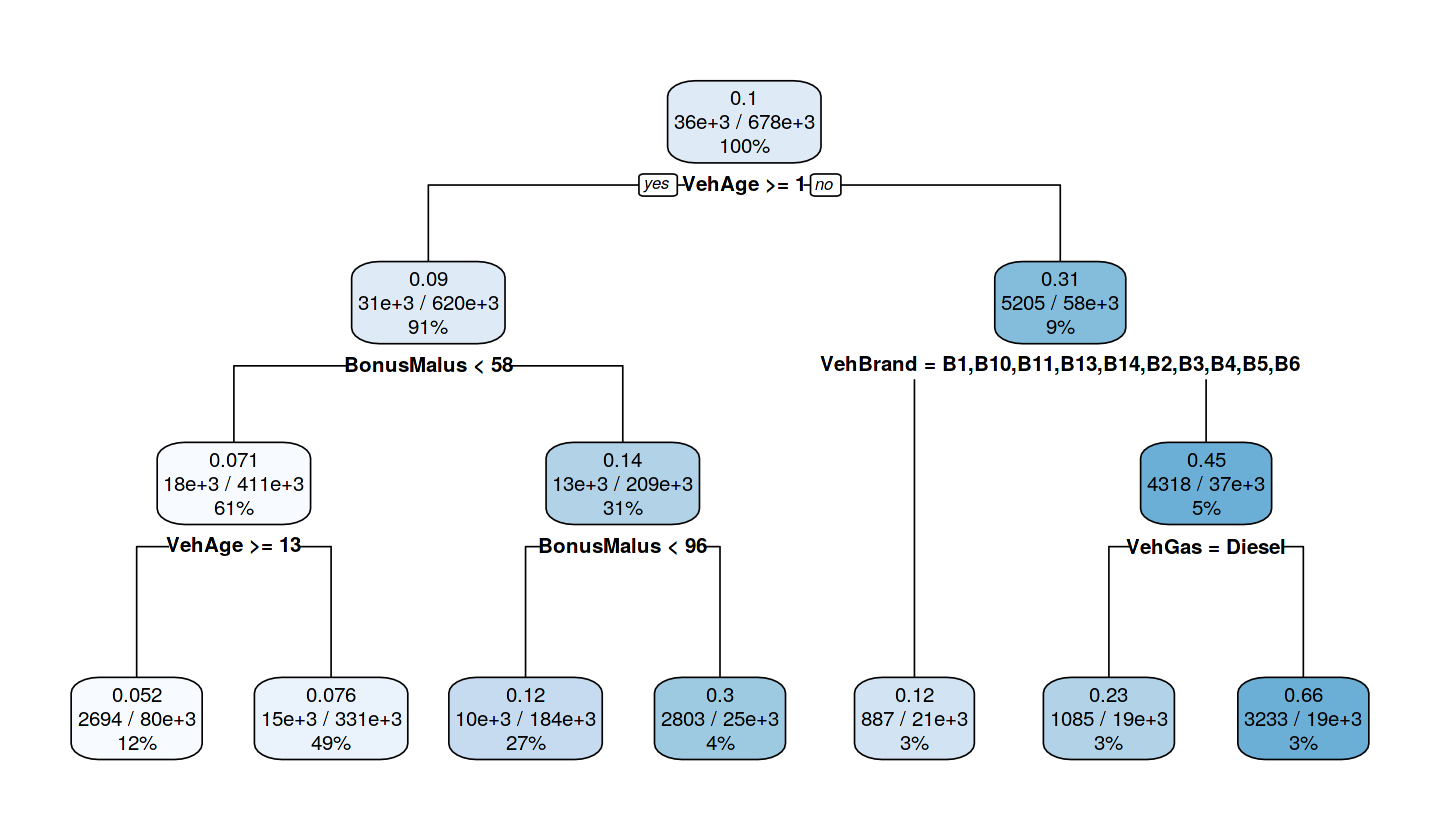

In [3]:
library(repr) # Scale plot size:
options(repr.plot.width=12, repr.plot.height = 7)

library(rpart.plot)
rpart.plot(tree) # display decision tree

The first line in the root node indicates the overall 10% claim frequency, the second line #claims/#exposure and the third line the exposure-proportion, which is 100% at the root node.

The root node is split (metric: gini impurity) into two more homogeneous groups by "vehicle age >= 1" year. 
Insurance policies that meet this condition are shown on the left. Thus policies for new cars are displayed on the right. 
While 9% of the cars are new (VehAge=0), their claim frequency is 31%. Depending on vehicle brand (VehBrand) and fuel (VehGas) it is up to 66%.

In contrast, the claim frequency on the left side of the decision tree is only 5%, depending on the “BonusMalus”-value and again the age of the vehicle. We will therefore take a closer look at these variables in the next section.


## 1.3 Explorative data analysis

In this section we try to get more insight into the data. We use some functions of the R-"Tidyverse" and the pipe operator %>% to make the code more readable.




In [4]:
#library(tidyverse) # work quietly:
suppressMessages(library(tidyverse))

#### a) 1.3.1 Car brand, car age and fuel
With regard to the right hand side of the decision tree, we first consider the claim frequencies depending on car brand, car age and fuel for groups with a minimum exposure of 100. By this we can reproduce the claim frequency of 66% for non-diesel new cars of brand B12.

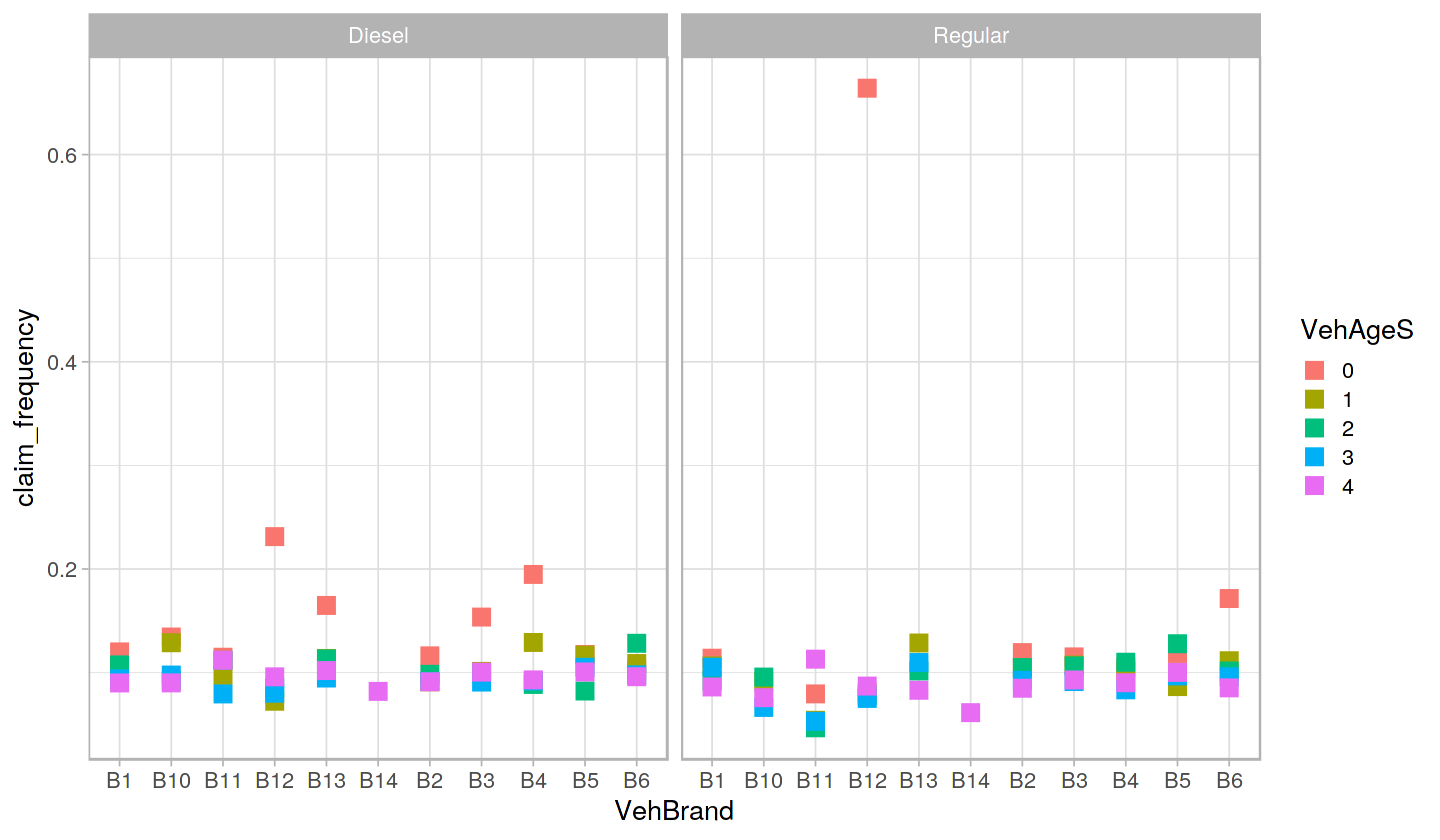

In [5]:
# To focus on new car effects, all cars from the age of four belong to the same group in the following plot:
dat %>% 
  mutate(VehAgeS=as.factor(pmin(VehAge, 4))) %>% 
  group_by(VehBrand,VehAgeS,VehGas) %>% 
  summarize(claim_frequency=sum(as.double(ClaimNb))/sum(Exposure), expo=sum(Exposure)) %>% 
  filter(expo>=100)  %>% 
  ggplot(aes(x=VehBrand, y=claim_frequency, color=VehAgeS)) + 
  facet_grid(. ~ VehGas) + 
  geom_point(size=5,shape=15) + theme_light(base_size = 16)

By this we can reproduce the claim frequency of 66% for non-diesel new cars of brand B12.

#### b) Car age and BonusMalus
Next we look at interactions of vehicle age and Bonus-Malus-ranges (deductible). The data are filtered to avoid the new-car-effects of car brand B12 and very small groups with BonusMalus greater than 125%. To avoid noisy effects of very small groups all cars from the age of twenty belong to the same group. 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



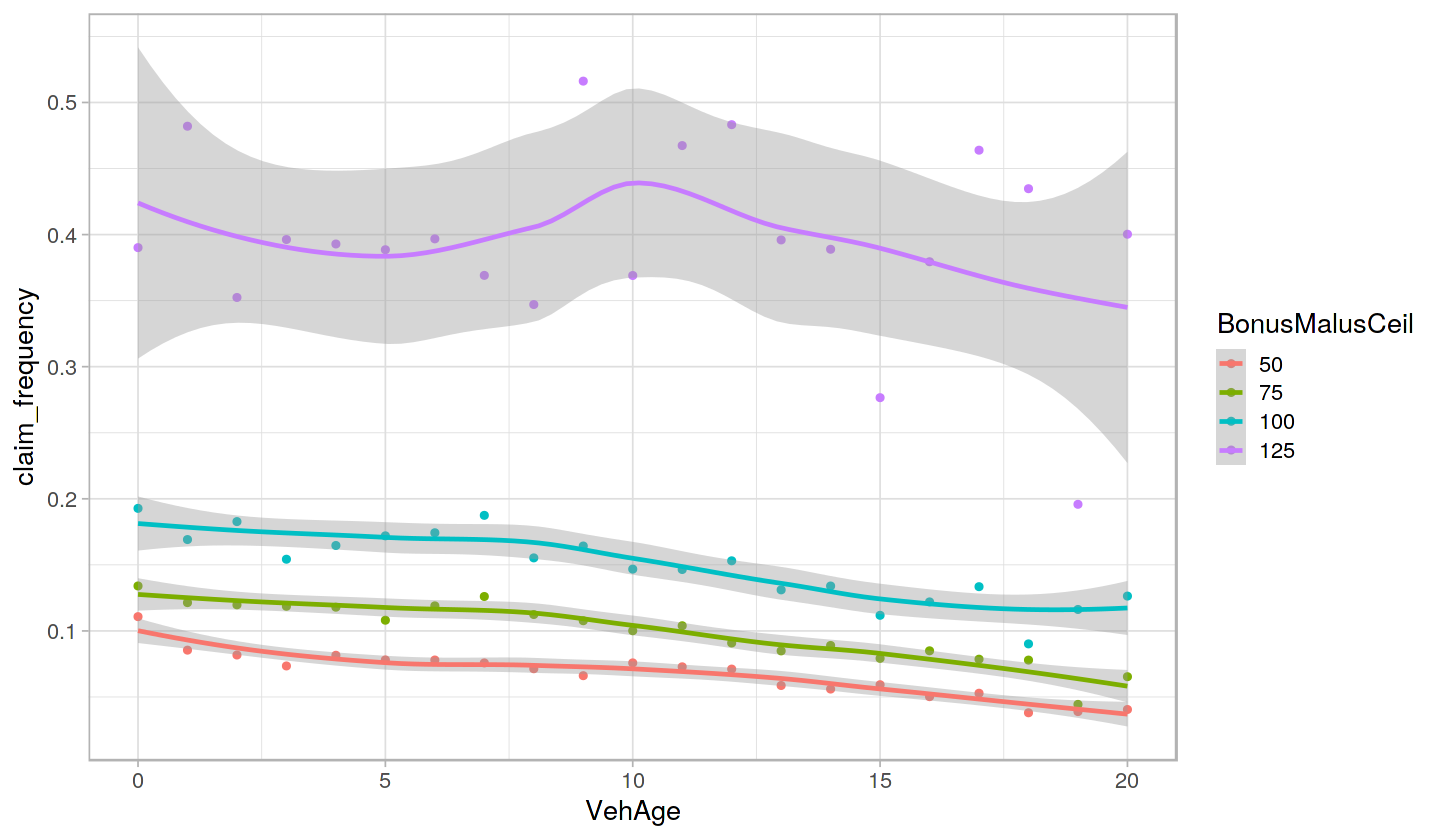

In [6]:
dat %>% 
  filter(VehBrand!='B12' & BonusMalus<=125)  %>% 
  mutate(VehAge=pmin(VehAge,20),
         BonusMalusCeil=as.factor(ceiling(BonusMalus/25)*25)) %>% 
  group_by(VehAge,BonusMalusCeil) %>% 
  summarize(claim_frequency=sum(as.double(ClaimNb))/sum(Exposure)) %>% 
  ggplot(aes(x=VehAge, y=claim_frequency, color=BonusMalusCeil)) + 
  geom_point() + geom_smooth() + theme_light(base_size = 16)

#### c) Driver age and BonusMalus
There might also be effects of driver age and Bonus-Malus. To avoid noisy effects of very small groups policies with BonusMalus>125 are excluded, driver age is grouped in five-year steps, all driver from the age of 85 belong to the same group and all cars from the age of twenty belong to the same group. 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



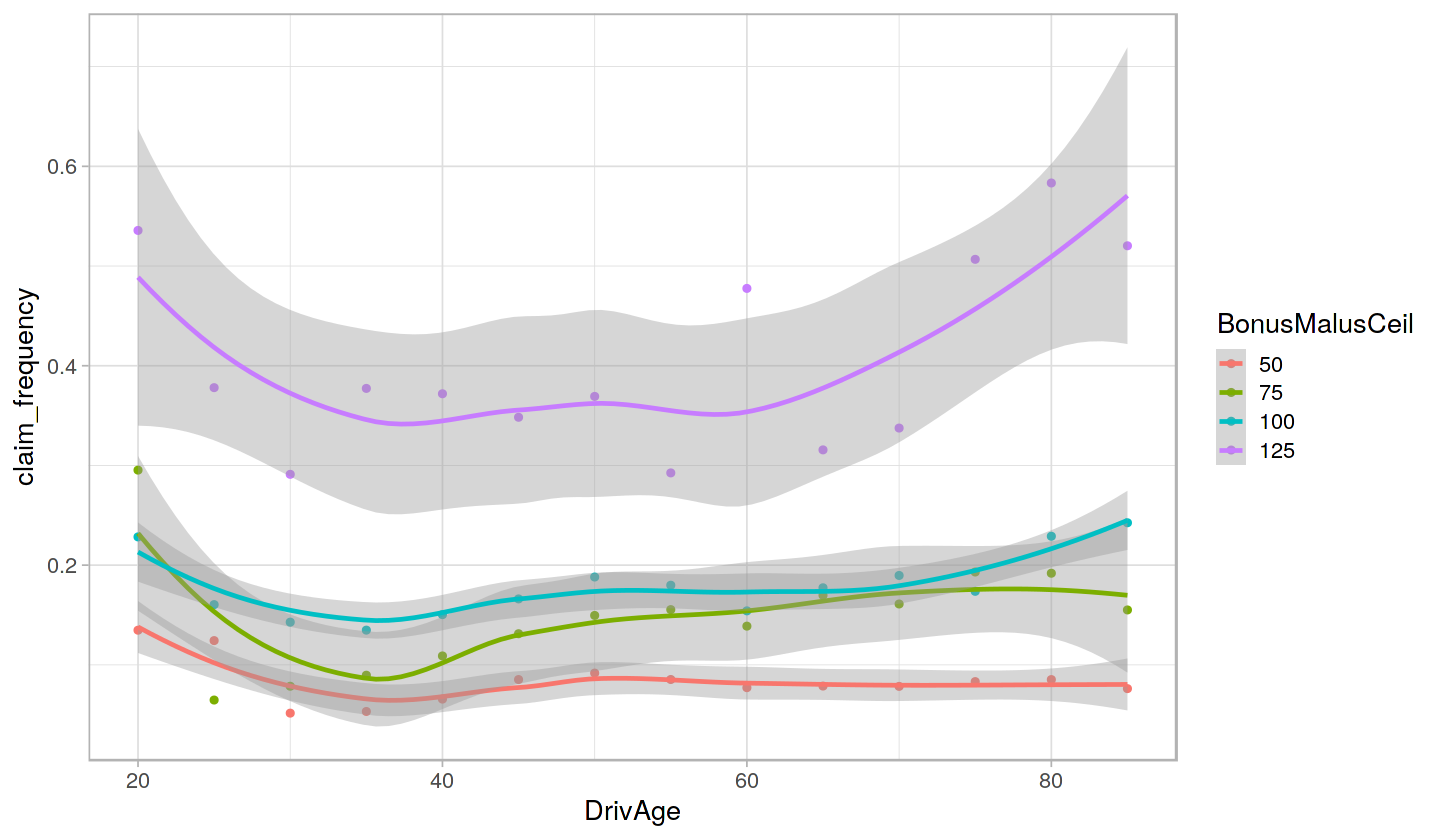

In [7]:
# To avoid noisy effects of very small groups we limit the on BonusMalus up to 125% driver age is grouped in five-year steps. 
# Further all driver from the age of 85 belong to the same group. 
dat %>% 
  filter(BonusMalus<=125)  %>% 
  mutate(DrivAge=ceiling(pmin(DrivAge,85)/5)*5,
         BonusMalusCeil=as.factor(ceiling(BonusMalus/25)*25)) %>% 
  group_by(DrivAge,BonusMalusCeil) %>% 
  summarize(claim_frequency=sum(as.double(ClaimNb))/sum(Exposure)) %>% 
  ggplot(aes(x=DrivAge, y=claim_frequency, color=BonusMalusCeil)) + 
  geom_point() + geom_smooth() + theme_light(base_size = 16)

It could also be interesting to investigate this interaction via the number of claims in a violin plot:

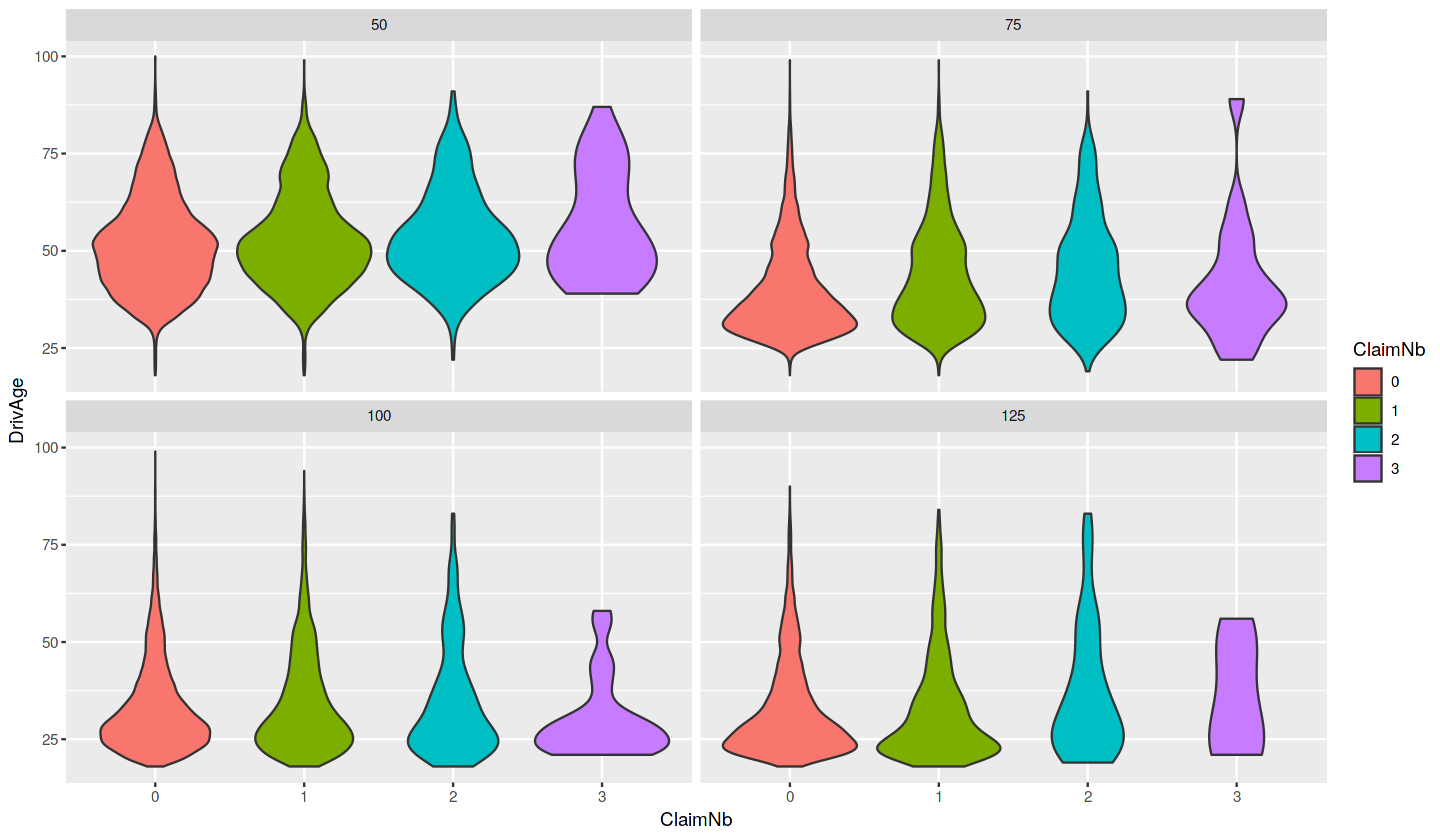

In [8]:
# Violin plot DrivAge vs number of claims for BonusMalus-groups:
dat %>% filter(ClaimNb<4 & BonusMalus<=125) %>% 
  mutate(BonusMalusCeil=as.factor(ceiling(BonusMalus/25)*25), 
         ClaimNb=as.factor(ClaimNb)) %>% 
  ggplot(aes(ClaimNb, DrivAge)) + 
  geom_violin(aes(fill = ClaimNb)) +
  facet_wrap(~BonusMalusCeil)


The most striking is the different age distribution of the drivers with three claims, but this group is very small, see the following table:

In [9]:
# View distribution of all claims 
table(dat$ClaimNb)


     0      1      2      3      4 
643953  32178   1784     82     16 

#### d) Vehicle power and fuel
There seem to be other interesting interactions:

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



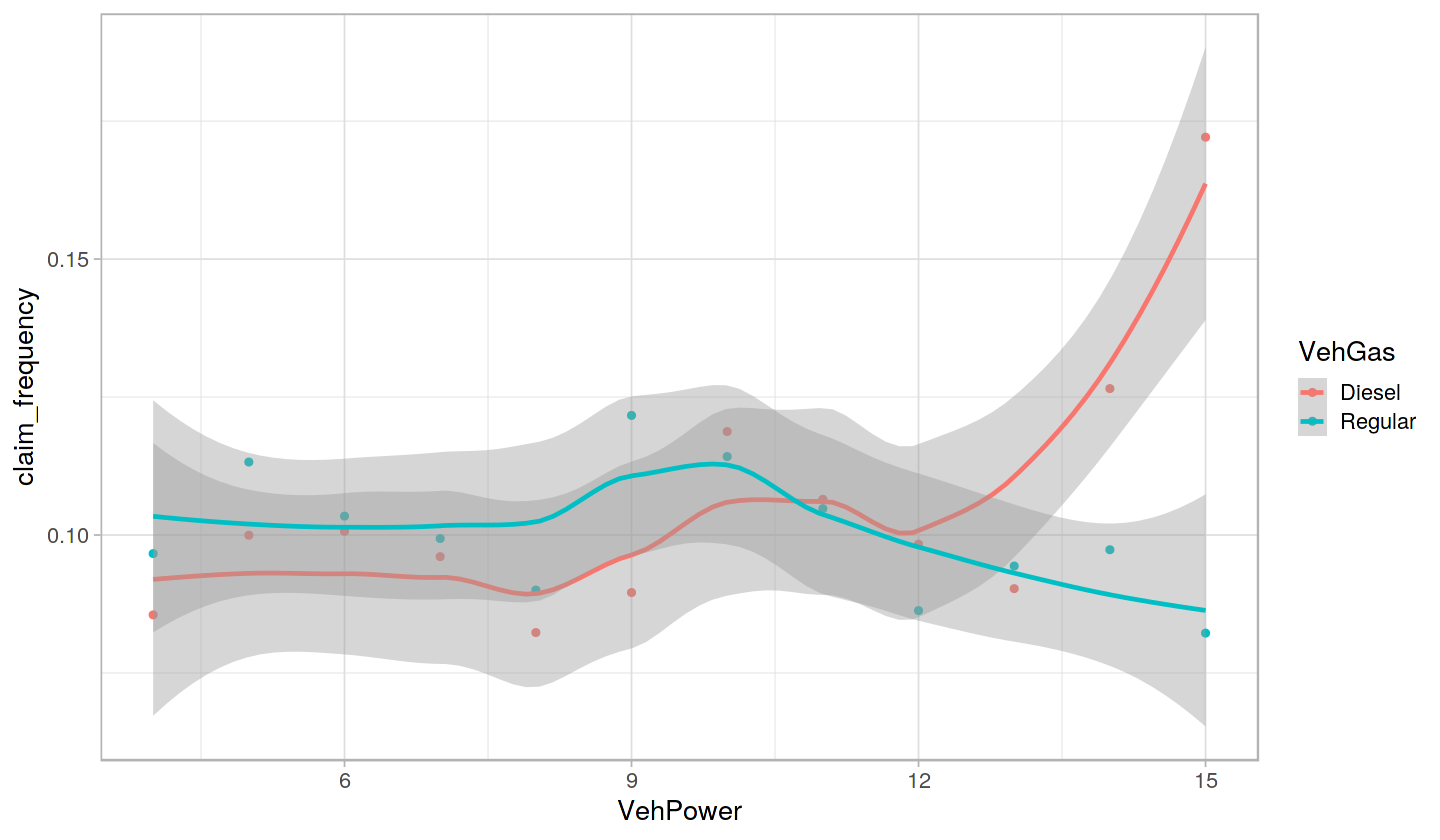

In [10]:
dat %>% 
#  filter(VehBrand!='B12')  %>% # 2.
  group_by(VehGas,VehPower) %>% 
  summarize(claim_frequency=sum(as.double(ClaimNb))/sum(Exposure)) %>% 
  ggplot(aes(x=VehPower, y=claim_frequency, color=VehGas)) + 
  geom_point() + geom_smooth() + theme_light(base_size = 16)    

Hint: This looks quit different without brand B12. 



## 1.4 Feature preprocessing for GLM
Since car brand B12's new cars with regular fuel behave so special we create a new variable with a dummy brand "B12RN" (regular, new):


In [11]:
# "B12 regular, new car fleet"
dat$VehBrand2 <- as.factor(ifelse(dat$VehBrand=='B12' & dat$VehAge==0 & dat$VehGas =='Regular', 'B12RN', as.character(dat$VehBrand)))

dat %>% 
  group_by(VehBrand2) %>% 
  summarise_at(vars(ClaimNb,Exposure), list(~sum(.), ~mean(.)))

VehBrand2,ClaimNb_sum,Exposure_sum,ClaimNb_mean,Exposure_mean
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
B1,8639,95314.990,0.05308598,0.5857032
B10,858,9489.844,0.04845541,0.5359374
B11,721,6883.077,0.05307324,0.5066674
B12,5626,59934.250,0.03814651,0.4063780
B12RN,3233,4868.129,0.17437972,0.2625744
B13,649,6768.032,0.05329282,0.5557589
B14,166,2270.508,0.04101804,0.5610348
B2,8552,94823.757,0.05349648,0.5931638
B3,2818,28576.436,0.05277648,0.5351894


In [12]:
# For comparison: sums and means across all brands
dat %>% summarise_at(vars(ClaimNb,Exposure), list(~sum(.), ~mean(.)))

ClaimNb_sum,Exposure_sum,ClaimNb_mean,Exposure_mean
<dbl>,<dbl>,<dbl>,<dbl>
36056,358360.1,0.05317892,0.5285446


"B12RN"s exposure is 0.26 and thus just half as high as the average exposure. On the other hand the mean claim number per policy is more than three times the average. Thus the claim frequency is over six times the average.

Concludingly, we perform the feature preprocessing according to Schelldorfer and Wüthrich (2019):

In [13]:
dat2 <- dat
dat2$AreaGLM <- as.integer(dat2$Area)
dat2$VehPowerGLM <- as.factor(pmin(dat2$VehPower,9))
VehAgeGLM <- cbind(c(0:110), c(1, rep(2,10), rep(3,100)))
dat2$VehAgeGLM <- as.factor(VehAgeGLM[dat2$VehAge+1,2])
dat2[,"VehAgeGLM"] <-relevel(dat2[,"VehAgeGLM"], ref="2")
DrivAgeGLM <- cbind(c(18:100), c(rep(1,21-18), rep(2,26-21), rep(3,31-26), rep(4,41-31), rep(5,51-41), rep(6,71-51), rep(7,101-71)))
dat2$DrivAgeGLM <- as.factor(DrivAgeGLM[dat2$DrivAge-17,2])
dat2[,"DrivAgeGLM"] <-relevel(dat2[,"DrivAgeGLM"], ref="5")
dat2$BonusMalusGLM <- as.integer(pmin(dat2$BonusMalus, 150))
dat2$DensityGLM <- as.numeric(log(dat2$Density))
dat2[,"Region"] <-relevel(dat2[,"Region"], ref="R24")
head(dat2) # show first few policies and generated features

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,VehBrand2,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM
,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<int>,<dbl>
1,1,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,B12RN,4,5,1,6,50,7.104144
2,3,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,B12RN,4,5,1,6,50,7.104144
3,5,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,B12,2,6,2,6,50,3.988984
4,10,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,B12,2,7,1,5,50,4.330733
5,11,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,B12,2,7,1,5,50,4.330733
6,13,1,0.52,E,6,2,38,50,B12,Regular,3003,R31,B12,5,6,2,4,50,8.007367


## 1.5 Next Year's Bonus-Malus


In [14]:
# Calculate next year's bonus-malus in range 54-125 (preparation for chapter 8) 

# Define Bonus-function (guessed from BonusMalus-bands, see frequency table and ch.8)
Bonus <- function(x) {
  a <- ifelse(x>125,0,ifelse(x==125,118,ifelse(x>100,x-6,ifelse(x>80,x-5,ifelse(x>60,x-4,ifelse(x>=54,x-3,0))))))
  return(a)
}

# BonusMalus 1 year later: 
dat.1y <- dat2
dat.1y$BonusMalusGLM <- Bonus(dat2$BonusMalusGLM)

## 1.6 Evaluation metrics and helper functions

In [15]:
# Function PD: Calculate Poisson Deviance
PD <- function(pred, obs) {200*(sum(pred)-sum(obs)+sum(log((obs/pred)^(obs))))/length(pred)}

# Function PD2: Print Poisson Deviance learn/test
PD2 <- function(txt, l.c, l.x, t.c, t.x) {
    sprintf("%s, Learn/Test: %.2f%% / %.2f%%", txt, PD(l.c, l.x), PD(t.c, t.x)) 
}

# Function CF2: Print claim frequency
CF2 <- function(txt, l.c, l.x, t.c, t.x) {
    sprintf("%s: %.2f%% / %.2f%%", txt, sum(l.c)/sum(l.x)*100, sum(t.c)/sum(t.x)*100) 
}

# Function Benchmark.GLM2: Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2 <- function(txt, pred, obs) {
  index <- ((PD(pred, obs) - PD(test$fit.cf, test$ClaimNb)) / (PD(test$fitGLM2, test$ClaimNb) - PD(test$fit.cf, test$ClaimNb))) * 100
  sprintf("GLM2-Improvement-Index (PD test) of %s: %.1f%%", txt, index) 
}

## 1.7 choosing learning (training) and test sample

In this case, the learning sample randomly takes 80% and the test sample 20% of the data sets.

In [16]:
# for later use (Ch.5) we create five 20%-subsamples ("folds") and take the last fold as the holdout data set
k <- 5
set.seed(42)
fold <- sample(1:k, nrow(dat2), replace = TRUE)
dat2$fold <- fold
learn <- dat2[dat2$fold != 5,]    # 80%
test <- dat2[ dat2$fold == 5,]    # 20%
CF2("Claim Frequency (Actual) Learn/Test", learn$ClaimNb,learn$Exposure, test$ClaimNb,test$Exposure)

[1] "Claim Frequency (Actual) Learn/Test: 10.06% / 10.05%"

## 1.8 Model INT (intercept-only)
The model "INT" consists solely of the intercept. It should give an impression of how much or little of the overall variation can be explained by classical and machine learning models. 

In [17]:
# Model INT "predictions"
cf <- sum(learn$ClaimNb)/sum(learn$Exposure) # claim frequency
learn$fit.cf <- cf*learn$Exposure
test$fit.cf <- cf*test$Exposure
# Print Poisson Deviance
PD2("Poisson Deviance INT", learn$fit.cf,learn$ClaimNb, test$fit.cf,test$ClaimNb)

[1] "Poisson Deviance INT, Learn/Test: 33.09% / 32.79%"

In [18]:
# Print claim frequency actual vs predicted (Intercept model)
CF2("Claim Frequency INT, Test-Sample, Actual/Predicted", test$ClaimNb,test$Exposure, test$fit.cf,test$Exposure)

[1] "Claim Frequency INT, Test-Sample, Actual/Predicted: 10.05% / 10.06%"

As expected, the predicted claim frequency of the test sample corresponds to the actual claim frequency of the learning sample.

<a id="ch2"></a>
# 2. Classics: Generalized Linear Models (GLM)

"The industry has widely adopted generalized linear models (GLMs) as a standard approach to modeling claims" is stated in this 2019 machine learning report: https://www.soa.org/globalassets/assets/files/resources/research-report/2019/machine-learning-methods.pdf . Thus we consider GLMs as well known and give it a try on this data set.

## 2.1 Basic "GLM2" (focus on driver age)
Our first GLM is developed in Schelldorfer and Wüthrich (2019) with a focus on driver age and called GLM2.

In [19]:
d.glm2 <- glm(ClaimNb ~ VehPowerGLM + VehAgeGLM + BonusMalusGLM
              + VehBrand + VehGas + DensityGLM + Region + AreaGLM +
                DrivAge + log(DrivAge) +  I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4), 
              data=learn, offset=log(Exposure), family=poisson())

summary(d.glm2) # print fit statistics and parameter list


Call:
glm(formula = ClaimNb ~ VehPowerGLM + VehAgeGLM + BonusMalusGLM + 
    VehBrand + VehGas + DensityGLM + Region + AreaGLM + DrivAge + 
    log(DrivAge) + I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4), 
    family = poisson(), data = learn, offset = log(Exposure))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9577  -0.3785  -0.2895  -0.1633   6.7811  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    6.907e+01  5.466e+00  12.634  < 2e-16 ***
VehPowerGLM5   1.976e-01  2.036e-02   9.706  < 2e-16 ***
VehPowerGLM6   2.225e-01  2.029e-02  10.962  < 2e-16 ***
VehPowerGLM7   1.432e-01  2.004e-02   7.148 8.79e-13 ***
VehPowerGLM8  -6.858e-02  3.024e-02  -2.268 0.023326 *  
VehPowerGLM9   2.239e-01  2.237e-02  10.007  < 2e-16 ***
VehAgeGLM1     1.165e+00  1.816e-02  64.166  < 2e-16 ***
VehAgeGLM3    -2.036e-01  1.493e-02 -13.637  < 2e-16 ***
BonusMalusGLM  2.315e-02  3.803e-04  60.876  < 2e-16 ***
VehBrandB10   -3.495e-02  4.186e-0

In [20]:
# make predictions
learn$fitGLM2 <- fitted(d.glm2)
test$fitGLM2 <- predict(d.glm2, newdata=test, type="response")
dat$fitGLM2 <- predict(d.glm2, newdata=dat2, type="response") 

# Predict with next year's bonus-malus (in range 51-124, preparation for chapter 8)
dat$fitGLM2.1y <- predict(d.glm2, newdata=dat.1y, type="response")

# Print claim frequency actual vs predicted
CF2("Claim Frequency GLM2, Test-Sample, Actual/Predicted", test$ClaimNb,test$Exposure, test$fitGLM2,test$Exposure)

[1] "Claim Frequency GLM2, Test-Sample, Actual/Predicted: 10.05% / 10.06%"

The predicted claim frequency is in the learn/test-range and thus fine. 

How does Poisson Deviance change?

In [21]:
# Print Poisson Deviance
PD2("Poisson Deviance GLM2", learn$fitGLM2,learn$ClaimNb, test$fitGLM2,test$ClaimNb)

[1] "Poisson Deviance GLM2, Learn/Test: 31.40% / 31.14%"

**This is not a major improvement over 32.79% (the intercept-only model INT) for the Poisson deviation. Obviously there are no features that can clearly predict damage.**

## 2.2 GLM2S: GLM2 with dummy car brand "B12RN"
As shown in the first section, the dummy car brand "B12RN" (**R**egular fuel, **N**ew cars) behaves very differently. Therefore, we make a slight change to the GLM2 model and replace VehBrand with VehBrand2, which separates the "B12 Regular New" car fleet from other B12 vehicles.

In [22]:
d.glm2s <- glm(ClaimNb ~ VehPowerGLM + VehAgeGLM + BonusMalusGLM
              + VehBrand2 + VehGas + DensityGLM + Region + AreaGLM +
                DrivAge + log(DrivAge) +  I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4), 
              data=learn, offset=log(Exposure), family=poisson())

#summary(d.glm2s) # print fit statistics and parameter list (just remove #)

# make predictions
learn$fitGLM2S <- fitted(d.glm2s)
test$fitGLM2S <- predict(d.glm2s, newdata=test, type="response")
dat$fitGLM2S <- predict(d.glm2s, newdata=dat2, type="response") 

# Predict with next year's bonus-malus (in range 51-124, preparation for chapter 8)
dat$fitGLM2S.1y <- predict(d.glm2s, newdata=dat.1y, type="response")

# Print claim frequency actual vs predicted
#CF2("Claim Frequency GLM2, Test-Sample, Actual/Predicted", test$ClaimNb,test$Exposure, test$fitGLM2,test$Exposure)

# Print Poisson Deviance
PD2("Poisson Deviance GLM2S", learn$fitGLM2S,learn$ClaimNb, test$fitGLM2S,test$ClaimNb)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("GLM2S", test$fitGLM2S, test$ClaimNb)

[1] "Poisson Deviance GLM2S, Learn/Test: 31.10% / 30.81%"

[1] "GLM2-Improvement-Index (PD test) of GLM2S: 119.6%"

**This small model change in the GLM2S is an improvement of 20% compared to GLM2!**

# 3. Classics, Mixed: GLM and GLMM¶
Since dummy brand B12RN is so different we will now specify a special model for it. To avoid overfitting we try a mixed effects model for B12RN. In contrast to GLMs, in Generalized Linear **Mixed** Models (GLMMs) high errors lead to mean-reversion. This is a way to incorporate credibility.

For a short review on GLMMs see the "CAS MONOGRAPH NO. 5: GENERALIZED LINEAR MODELS FOR INSURANCE RATING" (2nd ed.), Chapter 10.1, https://www.casact.org/pubs/monographs/index.cfm?fa=goldburd-Khare-Tevet-monograph05 or browse this Swedish motor insurance example: https://www.kaggle.com/floser/claim-frequency-glms-and-glmms .

In [23]:
# Fleet: Select B12RN data
learn.ft <- learn[learn$VehBrand2=='B12RN',]
test.ft <- test[test$VehBrand2=='B12RN',]
CF2('Claim Frequency "Fleet" (Actual) Learn/Test', learn.ft$ClaimNb,learn.ft$Exposure, test.ft$ClaimNb,test.ft$Exposure)
# the Poisson deviance "Fleet" for GLM2 and GLM2S:
PD2("Poisson Deviance GLM2", learn.ft$fitGLM2,learn.ft$ClaimNb, test.ft$fitGLM2,test.ft$ClaimNb)
PD2("Poisson Deviance GLM2S", learn.ft$fitGLM2S,learn.ft$ClaimNb, test.ft$fitGLM2S,test.ft$ClaimNb)

[1] "Claim Frequency \"Fleet\" (Actual) Learn/Test: 65.88% / 68.67%"

[1] "Poisson Deviance GLM2, Learn/Test: 84.11% / 87.59%"

[1] "Poisson Deviance GLM2S, Learn/Test: 79.05% / 81.76%"

The Poisson Deviance for B12RN on the test data is 87.59% (GLM2) and 81.76% (GLM2s). We try to improve this in the next step in using a generalized linear mixed model consisting of a fixed effect variable VehPowerGLM and random effects variables DrivAgeGLM and Region

In [24]:
suppressMessages(library(lme4)) 
d.glmm.ft <- glmer(ClaimNb ~ VehPowerGLM + DensityGLM + (1|DrivAgeGLM) + (1|Region) + offset(log(Exposure)), family=poisson(link=log), data=learn.ft)
summary(d.glmm.ft) # the fixed effects estimates

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: ClaimNb ~ VehPowerGLM + DensityGLM + (1 | DrivAgeGLM) + (1 |  
    Region) + offset(log(Exposure))
   Data: learn.ft

     AIC      BIC   logLik deviance df.resid 
 16128.3  16196.9  -8055.2  16110.3    14945 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.210 -0.438 -0.233 -0.119 46.919 

Random effects:
 Groups     Name        Variance Std.Dev.
 Region     (Intercept) 0.04596  0.2144  
 DrivAgeGLM (Intercept) 0.02314  0.1521  
Number of obs: 14954, groups:  Region, 22; DrivAgeGLM, 7

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.53295    0.11503  -4.633 3.60e-06 ***
VehPowerGLM5  0.68213    0.04981  13.696  < 2e-16 ***
VehPowerGLM6  0.60015    0.06656   9.017  < 2e-16 ***
VehPowerGLM7 -0.25493    0.08131  -3.135  0.00172 ** 
VehPowerGLM8 -1.19641    0.16225  -7.374 1.66e-13 ***
VehPowerGLM9  0.03535    0.06

In [25]:
ranef(d.glmm.ft) #the random effects estimates. Average: 0

$Region
      (Intercept)
R24 -3.858757e-01
R11  4.327306e-02
R21 -7.086048e-02
R22  6.331522e-02
R23 -5.257505e-02
R25 -2.926511e-01
R26 -3.772410e-02
R31 -1.200239e-01
R41  2.364915e-01
R42  8.114570e-02
R43 -1.743021e-01
R52  1.067405e-01
R53 -5.316884e-02
R54  3.344458e-05
R72  2.312888e-02
R73  3.104367e-01
R74  1.197366e-01
R82  7.884232e-02
R83 -3.094592e-01
R91  1.751905e-01
R93  1.277402e-01
R94  1.816098e-01

$DrivAgeGLM
  (Intercept)
5  0.01921937
1 -0.01166220
2  0.10991334
3  0.08779750
4  0.17682535
6 -0.14558687
7 -0.21080423

with conditional variances for “Region” “DrivAgeGLM” 

In [26]:
# make predictions
learn.ft$fitGLMM <- fitted(d.glmm.ft)
test.ft$fitGLMM <- predict(d.glmm.ft, newdata=test.ft, type="response")
# Print claim frequency actual vs predicted
CF2('Claim Frequency "Fleet" GLMM, Test-Sample, Actual/Predicted', test.ft$ClaimNb,test.ft$Exposure, test.ft$fitGLMM,test.ft$Exposure)

# Print Poisson Deviance
PD2('Poisson Deviance "Fleet" GLMM', learn.ft$fitGLMM,learn.ft$ClaimNb, test.ft$fitGLMM,test.ft$ClaimNb)

[1] "Claim Frequency \"Fleet\" GLMM, Test-Sample, Actual/Predicted: 68.67% / 65.99%"

[1] "Poisson Deviance \"Fleet\" GLMM, Learn/Test: 73.80% / 76.88%"


Compared to GLM2, this means a Poisson deviance reduction of over 10%. 

Now let's fit the unchanged GLM2 model (which is identical to the GLM2S model without B12RN) to the other car brands:

In [27]:
# NoFleet: Select data (not B12RN)
learn.nf <- learn[learn$VehBrand2 !='B12RN',]
test.nf <- test[test$VehBrand2!='B12RN',]

d.glm2s.nf <- glm(ClaimNb ~ VehPowerGLM + VehAgeGLM + BonusMalusGLM + VehBrand2 + VehGas + DensityGLM + Region + AreaGLM 
                         + DrivAge + log(DrivAge) +  I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4), 
                data=learn.nf, offset=log(Exposure), family=poisson())

#summary(d.glm2s.nf) # (#don't) print fit statistics and parameter list

learn.nf$fitGLMM <- fitted(d.glm2s.nf)
test.nf$fitGLMM <- predict(d.glm2s.nf, newdata=test.nf, type="response")

In [28]:
# Preparation for chapter 8: Predict all data
dat2.ft <- dat2[dat2$VehBrand2=='B12RN',]
dat2.nf <- dat2[dat2$VehBrand2!='B12RN',]
dat2.ft$fitGLMM <- predict(d.glmm.ft, newdata=dat2.ft, type="response")
dat2.nf$fitGLMM <- predict(d.glm2s.nf, newdata=dat2.nf, type="response")
dat2.nf <- rbind(dat2.ft, dat2.nf)
dat2.nf <- dat2.nf[order(dat2.nf$IDpol),]
dat$fitGLMM <- dat2.nf$fitGLMM

In [29]:
# Preparation for chapter 8: Predict with next year's bonus-malus (in range 51-124)
dat.ft <- dat.1y[dat.1y$VehBrand2=='B12RN',]
dat.nf <- dat.1y[dat.1y$VehBrand2!='B12RN',]
dat.ft$fitGLMM.1y <- predict(d.glmm.ft, newdata=dat.ft, type="response")
dat.nf$fitGLMM.1y <- predict(d.glm2s.nf, newdata=dat.nf, type="response")
dat.nf <- rbind(dat.ft, dat.nf)
dat.nf <- dat.nf[order(dat.nf$IDpol),]
dat$fitGLMM.1y <- dat.nf$fitGLMM.1y

In [30]:
## bind results for learn and test sample and calculate Poisson Deviance and GLM"-Improvement-Index:
learn.s <- rbind(learn.ft,learn.nf)
test.s <- rbind(test.ft,test.nf)
# Print claim frequency actual vs predicted
CF2('Claim Frequency "Fleet" GLMM, Test-Sample, Actual/Predicted', test.s$ClaimNb,test.s$Exposure, test.s$fitGLMM,test.s$Exposure)
# Print Poisson Deviance
PD2('Poisson Deviance "Fleet" GLMM', learn.s$fitGLMM,learn.s$ClaimNb, test.s$fitGLMM,test.s$ClaimNb)
# Improvment in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("GLMM", test.s$fitGLMM, test.s$ClaimNb)

[1] "Claim Frequency \"Fleet\" GLMM, Test-Sample, Actual/Predicted: 10.05% / 10.04%"

[1] "Poisson Deviance \"Fleet\" GLMM, Learn/Test: 30.94% / 30.67%"

[1] "GLM2-Improvement-Index (PD test) of GLMM: 128.3%"

This is another 7% improvement over GLM2, in addition to the GLM2S improvement. Here we have applied the GLMM only to a 5% share of policies. The GLMM could be applied easily to all data and features with less populated classes like region or car brand.

Unfortunately, GLMMs require significantly more computing time than GLMs. And we need the computing time for the upcoming machine learning methods.

<a id="ch4"></a>
# 4. Machine learning improved GLMs
## 4.1 "GLM4" featuring neural net residual analyses

The interactions in this model were found using neural network residual analyzes, see "From Generalized Linear Models to Neural Networks, and Back" by Mario Wüthrich (SSRN-Preprint 3491790, 11.12.2019)


In [31]:
d.glm4 <- glm(ClaimNb ~ AreaGLM + VehPowerGLM * VehAgeGLM + VehAgeGLM * VehBrand 
                + VehGas * VehAgeGLM + DensityGLM + Region
                + BonusMalusGLM * log(DrivAge) + log(BonusMalusGLM) + I(BonusMalusGLM^2)
                + I(BonusMalusGLM^3) + I(BonusMalusGLM^4)
                + DrivAge + I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4), 
                data=learn, offset=log(Exposure), family=poisson())

# summary(d.glm4)

learn$fitGLM4 <- fitted(d.glm4)
test$fitGLM4 <- predict(d.glm4, newdata=test, type="response")
dat$fitGLM4 <- predict(d.glm4, newdata=dat2, type="response")

# Predict with next year's bonus-malus (in range 51-124, preparation for chapter 8)
dat$fitGLM4.1y <- predict(d.glm4, newdata=dat.1y, type="response")

# Print Poisson Deviance
PD2('Poisson Deviance GLM4', learn$fitGLM4,learn$ClaimNb, test$fitGLM4,test$ClaimNb)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("GLM4", test$fitGLM4, test$ClaimNb)


[1] "Poisson Deviance GLM4, Learn/Test: 30.92% / 30.64%"

[1] "GLM2-Improvement-Index (PD test) of GLM4: 129.8%"

So far the GLMM (GLM with mixed effects for the special "B12RN") and the GLM4 (with neural network generated interactions) are of comparable predicting power and our best models. We take a last attempt improving GLMs: 

## 4.2 "GLM5" Improved GLM with Interactions from XGBoost

The interactions in this model were found with XGBoost (see below, Chapter 6) residual analyzes using the EIX package.

In [32]:
d.glm5 <- glm(ClaimNb ~ AreaGLM + VehPowerGLM * VehAgeGLM  + VehAgeGLM *VehBrand
              + VehGas * VehAgeGLM + DensityGLM + Region
              + BonusMalusGLM * log(DrivAge) +  VehAgeGLM *log(BonusMalusGLM) + I(BonusMalusGLM^2)
              + I(BonusMalusGLM^3) + I(BonusMalusGLM^4)
              + DrivAge * DensityGLM + I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4),
              data=learn, offset=log(Exposure), family=poisson())

#summary(d.glm5)

learn$fitGLM5 <- fitted(d.glm5)
test$fitGLM5 <- predict(d.glm5, newdata=test, type="response")
dat$fitGLM5 <- predict(d.glm5, newdata=dat2, type="response")

# Predict with next year's bonus-malus (in range 51-124, preparation for chapter 8)
dat$fitGLM5.1y <- predict(d.glm5, newdata=dat.1y, type="response")

# Print Poisson Deviance
PD2('Poisson Deviance GLM5', learn$fitGLM5,learn$ClaimNb, test$fitGLM5,test$ClaimNb)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("GLM5", test$fitGLM5, test$ClaimNb)

[1] "Poisson Deviance GLM5, Learn/Test: 30.86% / 30.57%"

[1] "GLM2-Improvement-Index (PD test) of GLM5: 134.1%"

This is slightly better than the GLM4 and the GLMM. We now have three models with a PD improvement index between 128% and 135%. This seems to be the limit of the classical methods. 

Before we use machine learning methods, we examine the stability of our first results, see chapter 5. 

<a id="ch5"></a>
# 5. Cross Validation and Boxplots

So far we have trained the models once at 80% of all policies and tested it on a hold-out data set consisting of 20% of all policies. The results could be a bit arbitrary. We don't know if our models generalize well with respect to other test data.

In Chapter 1.6 we have already divided the data into five parts, which are called folds. Up to now we used fold no. 5 for testing. Now we repeat this for all five folds. This is called cross validation and considered the best way to avoid over-fitting.

Since this takes five times the execution time, we demonstrate this procedure with the less computation-intensive GLMs.

## 5.1 Repeat modeling k-times

In [33]:
# k folds as defined in Ch. 1.6

PD.test.INT  <- vector() # initialize PD-test-folds-vector
PD.test.GLM2 <- vector() # 
PD.test.GLM2S <- vector() # 
PD.test.GLM4 <- vector() 
PD.test.GLM5 <- vector() 

for (i in 1:k) {
    learn <- dat2[dat2$fold != i,]
    test <- dat2[dat2$fold == i,]
    (n_l <- nrow(learn))
    (n_t <- nrow(test))
    sum(learn$ClaimNb)/sum(learn$Exposure)

    ### Model INT (intercept-only).  No model, just average claim frequency
    (cf <- sum(learn$ClaimNb)/sum(learn$Exposure))
    test$fit.cf <- cf*test$Exposure
    # out-of-sample losses (in 10^(-2))
    PD.test.INT[i] <- PD(test$fit.cf, test$ClaimNb)
    
    ### Model GLM2: Basic GLM without interactions
    d.glm2 <- glm(ClaimNb ~ VehPowerGLM + VehAgeGLM + BonusMalusGLM
              + VehBrand + VehGas + DensityGLM + Region + AreaGLM 
              + DrivAge + log(DrivAge) +  I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4), 
              data=learn, offset=log(Exposure), family=poisson())
    test$fitGLM2 <- predict(d.glm2, newdata=test, type="response")
    PD.test.GLM2[i] <- PD(test$fitGLM2, test$ClaimNb)

    ### Model GLM2S: GLM2 with dummy car brand "B12RN"
    d.glm2s <- glm(ClaimNb ~ VehPowerGLM + VehAgeGLM + BonusMalusGLM
              + VehBrand2 + VehGas + DensityGLM + Region + AreaGLM 
              + DrivAge + log(DrivAge) +  I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4), 
              data=learn, offset=log(Exposure), family=poisson())
    test$fitGLM2S <- predict(d.glm2s, newdata=test, type="response")
    PD.test.GLM2S[i] <- PD(test$fitGLM2S, test$ClaimNb)
   
    ### Model GLM4: Featuring neural net residual analyses
    d.glm4 <- glm(ClaimNb ~ AreaGLM + VehPowerGLM * VehAgeGLM + VehAgeGLM * VehBrand 
              + VehGas * VehAgeGLM + DensityGLM + Region
              + BonusMalusGLM * log(DrivAge) + log(BonusMalusGLM) + I(BonusMalusGLM^2)
              + I(BonusMalusGLM^3) + I(BonusMalusGLM^4)
              + DrivAge + I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4), 
              data=learn, offset=log(Exposure), family=poisson())
    test$fitGLM4 <- predict(d.glm4, newdata=test, type="response")
    PD.test.GLM4[i] <- PD(test$fitGLM4, test$ClaimNb)
    
    ### Model GLM5: Improved GLM with Interactions from XGBoost
    d.glm5 <- glm(ClaimNb ~ AreaGLM + VehPowerGLM * VehAgeGLM  + VehAgeGLM * VehBrand
              + VehGas * VehAgeGLM + DensityGLM + Region
              + BonusMalusGLM * log(DrivAge) +  VehAgeGLM *log(BonusMalusGLM) + I(BonusMalusGLM^2)
              + I(BonusMalusGLM^3) + I(BonusMalusGLM^4)
              + DrivAge * DensityGLM + I(DrivAge^2) + I(DrivAge^3) + I(DrivAge^4),
              data=learn, offset=log(Exposure), family=poisson())
    test$fitGLM5 <- predict(d.glm5, newdata=test, type="response")
    PD.test.GLM5[i] <- PD(test$fitGLM5, test$ClaimNb)
}
k

[1] 5

In [34]:
# write vectors in a Data Frame
df <- data.frame(1:5,PD.test.INT,PD.test.GLM2,PD.test.GLM2S,PD.test.GLM4,PD.test.GLM5)
names(df) <- c("fold","INT","GLM2","GLM2S","GLM4","GLM5")
# calculate GLM2-Improvement-Index
df.idx <- df
df.idx$GLM2S<- round(((df$GLM2S- df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$GLM4 <- round(((df$GLM4 - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx$GLM5 <- round(((df$GLM5 - df$INT) / (df$GLM2 - df$INT)) * 100,2)
df.idx

fold,INT,GLM2,GLM2S,GLM4,GLM5
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,32.96344,31.36667,117.09,125.28,129.34
2,33.28906,31.57999,118.43,127.98,132.47
3,33.13300,31.42699,117.85,129.29,130.91
4,32.96120,31.28341,118.70,128.57,132.50
5,32.79164,31.13774,119.56,129.82,134.07


## 5.2 Plot Poisson Deviance for each fold

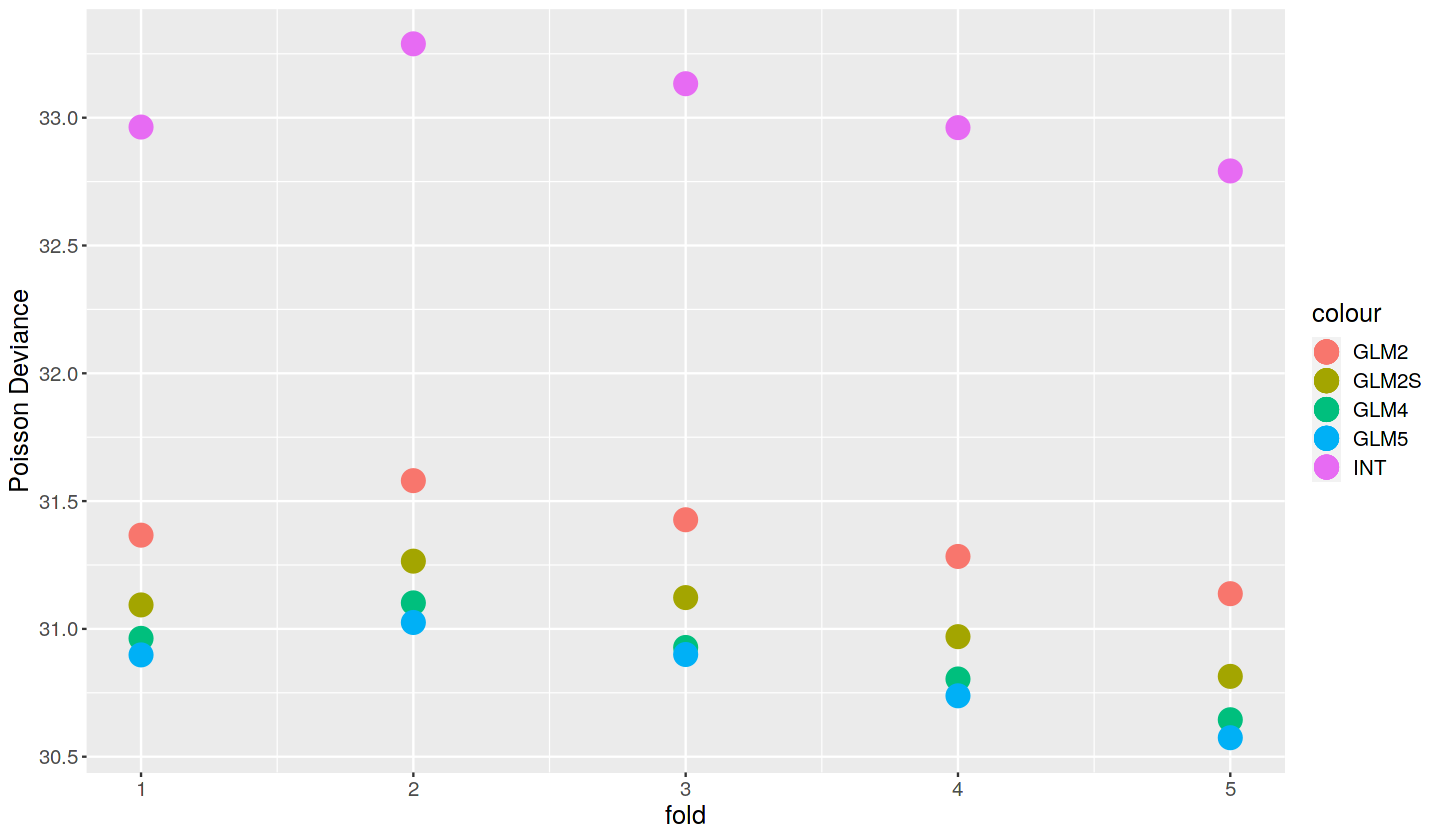

In [35]:
ggplot(df, aes(fold)) + 
  geom_point(aes(y = INT,  colour = "INT"),  size=6) + 
  geom_point(aes(y = GLM2, colour = "GLM2"), size=6) + 
  geom_point(aes(y = GLM2S,colour = "GLM2S"),size=6) + 
  geom_point(aes(y = GLM4, colour = "GLM4"), size=6) + 
  geom_point(aes(y = GLM5, colour = "GLM5"), size=6) + 
  ylab("Poisson Deviance") + theme(text = element_text(size=15)) 

We observe a similarity in distances between the models for each fold.

## 5.3 Visualize PD-folds in a boxplot

In [36]:
# transform data from wide to long
df.long <- gather(df[1:6],model,PD,INT,GLM2,GLM2S,GLM4,GLM5)
tail(df.long) #check

,fold,model,PD
,<int>,<chr>,<dbl>
20,5,GLM4,30.64451
21,1,GLM5,30.89819
22,2,GLM5,31.02504
23,3,GLM5,30.89975
24,4,GLM5,30.73819
25,5,GLM5,30.57420


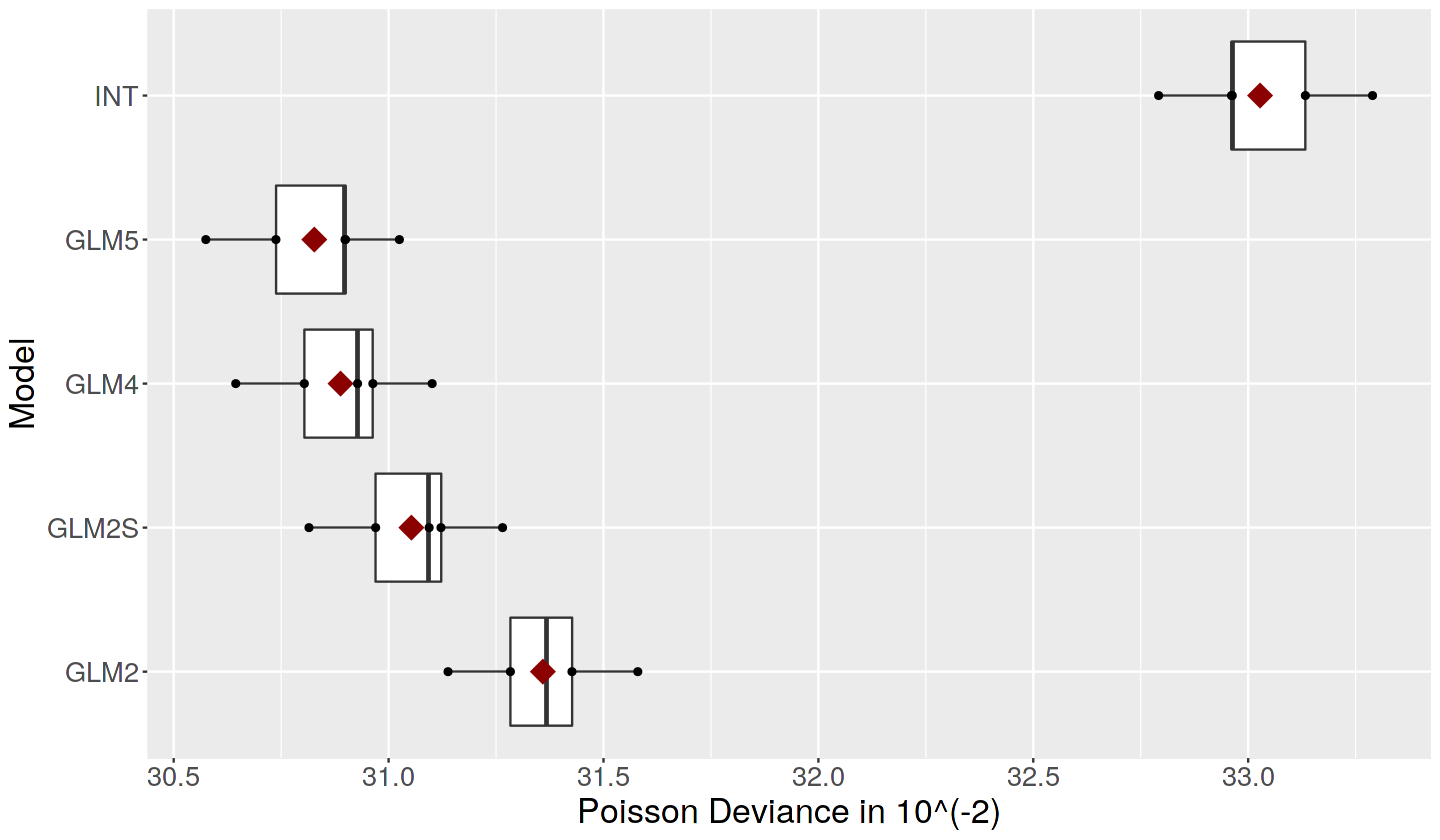

In [37]:
# create boxplot
ggplot(df.long, aes(model, PD)) +
  geom_boxplot(outlier.shape = NA) + 
  geom_jitter(width = 0) +
  stat_summary(fun = mean, colour="darkred", geom="point",shape=18, size=7) +
  coord_flip() +
  xlab("Model") + 
  ylab("Poisson Deviance in 10^(-2)") + 
  theme(text = element_text(size=20)) 

## 5.4 Plot GLM2-Improvement-Index

Since a substantial part of the uncertainty is caused by differences between folds we calculate the relative improvement with respect to the models INT ("no model") and our benchmark-model GLM2 

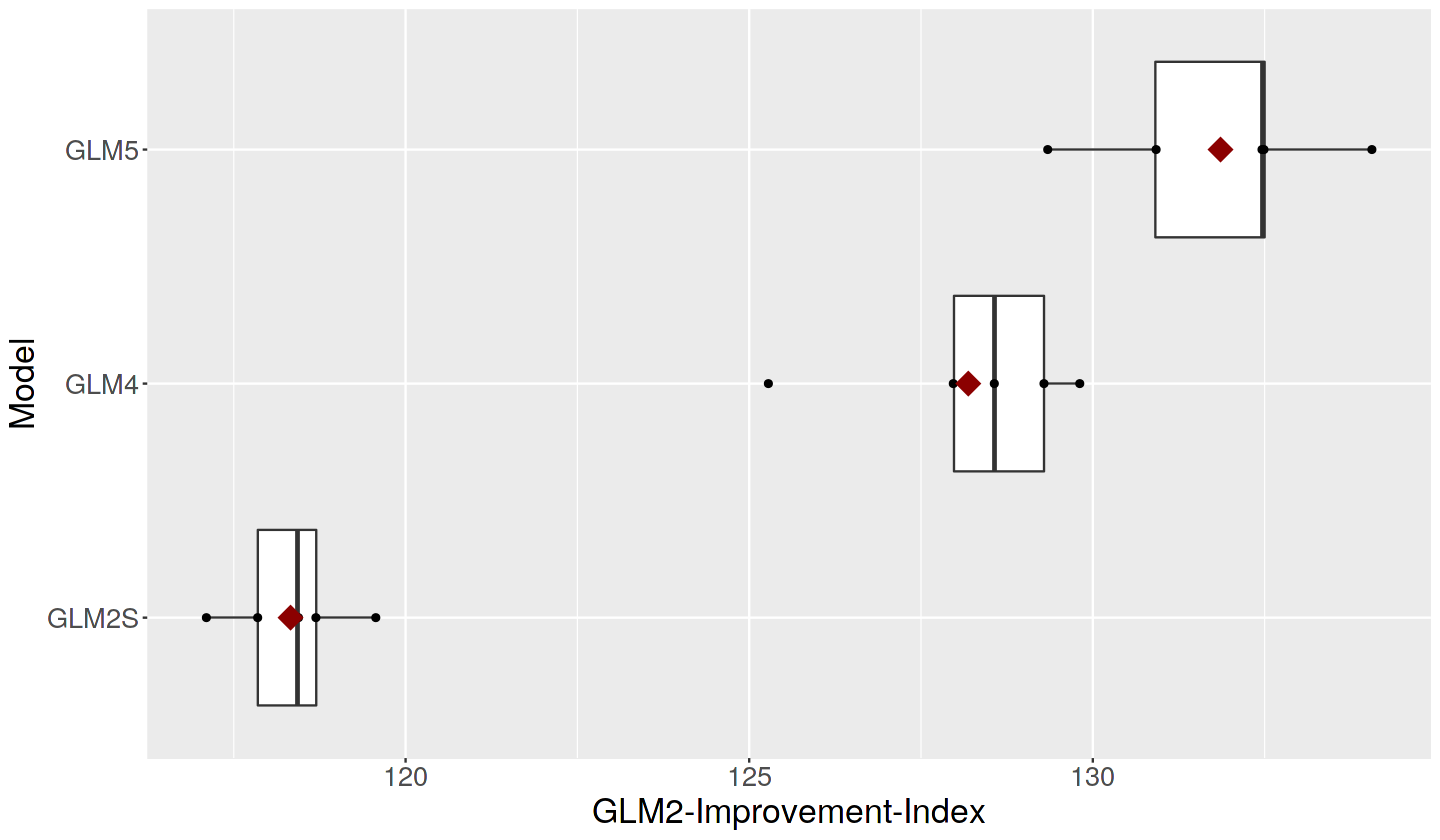

In [38]:
df.idx  %>% select(fold,GLM2S,GLM4,GLM5) %>% 
  gather(model,PD,GLM2S,GLM4,GLM5) %>% 
  ggplot(aes(model, PD)) +
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(width = 0) +
    stat_summary(fun = mean, colour="darkred", geom="point",shape=18, size=7) +
    coord_flip() +
    xlab("Model") + 
    ylab("GLM2-Improvement-Index") + 
    theme(text = element_text(size=20)) 

While in the previous boxplot the Poisson Deviance of the models GLM4 and GLM5 overlapped strongly, the boxes are now free of overlap and GLM5 is clearly the best model so far.

In Chapter 9, we add the results of the following machine learning models to this diagram.


<a id="ch6"></a>
# 6. Deep Learning Approach with Embeddings and the "CANN"
This is basically a replication of the deep learning models published by Schelldorfer and Wüthrich (2019). The neural networks implemented are fairly small, the focus in this article is not on optimizing hyperparameters. Instead, very interesting ideas such as embeddings and the combined actuarial neural network (CANN) are demonstrated. For further information we recommend the article and the references therein. A brief overview can be found in this presentation (page 6 to 8): https://ethz.ch/content/dam/ethz/special-interest/math/risklab-dam/documents/risk-day/risk-day-2019/Schelldorfer_2019_09_11.pdf . 

Most of the code in this chapter was written and generously shared by Mario Wuthrich, see https://github.com/JSchelldorfer/ActuarialDataScience, Tutorial 3, file "01 CANN approach.r" (February 5, 2019).


## 6.1 Pre-Processing

In [39]:
# feature pre-processing 

# min-max-scaler:
PreProcess.Continuous <- function(var1, dat2){
  names(dat2)[names(dat2) == var1]  <- "V1"
  dat2$X <- as.numeric(dat2$V1)
  dat2$X <- 2*(dat2$X-min(dat2$X))/(max(dat2$X)-min(dat2$X))-1
  names(dat2)[names(dat2) == "V1"]  <- var1
  names(dat2)[names(dat2) == "X"]  <- paste(var1,"X", sep="")
  dat2
}

# pre-procecessing function:
Features.PreProcess <- function(dat2){
  dat2 <- PreProcess.Continuous("Area", dat2)   
  dat2 <- PreProcess.Continuous("VehPower", dat2)   
  dat2$VehAge <- pmin(dat2$VehAge,20)
  dat2 <- PreProcess.Continuous("VehAge", dat2)   
  dat2$DrivAge <- pmin(dat2$DrivAge,90)
  dat2 <- PreProcess.Continuous("DrivAge", dat2)   
  dat2$BonusMalus <- pmin(dat2$BonusMalus,150)
  dat2 <- PreProcess.Continuous("BonusMalus", dat2)   
  dat2$VehBrandX <- as.integer(dat2$VehBrand)-1
  dat2$VehGasX <- as.integer(dat2$VehGas)-1.5
  dat2$Density <- round(log(dat2$Density),2)
  dat2 <- PreProcess.Continuous("Density", dat2)   
  dat2$RegionX <- as.integer(dat2$Region)-1  # char R11,,R94 to number 0,,21
  dat2
}

dat2 <- Features.PreProcess(dat[,c(1:12,14)])  # keep original variables and fitGLM2 (CANN)

# Generate small random sample to inspect transformations
sample_n(dat2[4:22], 12) 

Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,fitGLM2,AreaX,VehPowerX,VehAgeX,DrivAgeX,BonusMalusX,VehBrandX,VehGasX,DensityX,RegionX
<fct>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D,13,20,53,57,B10,Diesel,6.51,R93,0.080419151,0.2,0.6363636,1.0,-0.02777778,-0.86,1,-0.5,0.27647059,20
B,5,5,80,50,B3,Diesel,4.20,R24,0.042138617,-0.6,-0.8181818,-0.5,0.72222222,-1.00,7,-0.5,-0.17647059,4
F,11,5,42,50,B12,Regular,10.20,R11,0.076361996,1.0,0.2727273,-0.5,-0.33333333,-1.00,3,0.5,1.00000000,0
D,5,7,42,68,B2,Diesel,7.19,R93,0.009813980,0.2,-0.8181818,-0.3,-0.33333333,-0.64,6,-0.5,0.40980392,20
C,12,3,41,50,B12,Regular,5.67,R11,0.034143780,-0.2,0.4545455,-0.7,-0.36111111,-1.00,3,0.5,0.11176471,0
C,6,5,34,55,B5,Diesel,5.84,R93,0.066935129,-0.2,-0.6363636,-0.5,-0.55555556,-0.90,9,-0.5,0.14509804,20
F,7,9,31,64,B2,Diesel,10.20,R11,0.004244979,1.0,-0.4545455,-0.1,-0.63888889,-0.72,6,-0.5,1.00000000,0
A,5,3,80,55,B1,Regular,3.76,R24,0.101687428,-1.0,-0.8181818,-0.7,0.72222222,-0.90,0,0.5,-0.26274510,4
D,5,0,46,50,B2,Regular,7.03,R11,0.053548737,0.2,-0.8181818,-1.0,-0.22222222,-1.00,6,0.5,0.37843137,0


In [40]:
# view results of min-max-scaler on VehPower:
table(dat2$VehPower)
table(round(dat2$VehPowerX,3))


     4      5      6      7      8      9     10     11     12     13     14 
115349 124821 148976 145401  46956  30085  31354  18352   8214   3229   2350 
    15 
  2926 


    -1 -0.818 -0.636 -0.455 -0.273 -0.091  0.091  0.273  0.455  0.636  0.818 
115349 124821 148976 145401  46956  30085  31354  18352   8214   3229   2350 
     1 
  2926 

In [41]:
# choosing learning and test sample (based on folds)
dat2$fold <- fold
learn <- dat2[dat2$fold != 5,]    # 80%
test <- dat2[ dat2$fold == 5,]    # 20%
learn0 <- learn
test0 <- test
learn1 <- learn
test1 <- test
learn2 <- learn
test2 <- test

CF2("Claim Frequency (Actual) Learn/Test", learn$ClaimNb,learn$Exposure, test$ClaimNb,test$Exposure)

[1] "Claim Frequency (Actual) Learn/Test: 10.06% / 10.05%"

In [42]:
# setting up the matrices
features <- c(14:18, 20:21) # definition of feature variables (non-categorical)
q0 <- length(features)
# learning data
Xlearn <- as.matrix(learn[, features])  # design matrix learning sample
Brlearn <- as.matrix(learn$VehBrandX)
Relearn <- as.matrix(learn$RegionX)
Ylearn <- as.matrix(learn$ClaimNb)
# testing data
Xtest <- as.matrix(test[, features])    # design matrix test sample
Brtest <- as.matrix(test$VehBrandX)
Retest <- as.matrix(test$RegionX)
Ytest <- as.matrix(test$ClaimNb)
# choosing the right volumes for EmbNN and CANN
Vlearn <- as.matrix(log(learn$Exposure))
Vtest <- as.matrix(log(test$Exposure))

print(paste("Number of basic features (without VehBrand and Region):",q0))
(lambda.hom <- sum(learn$ClaimNb)/sum(learn$Exposure)) 

[1] "Number of basic features (without VehBrand and Region): 7"


[1] 0.1006349

## 6.2 Setting up the Common Neural Network Architecture

In [43]:
# hyperparameters of the neural network architecture (as specified in "01 CANN approach.r") 
q1 <- 20 # Number of neuron in hidden layer 1
q2 <- 15
q3 <- 10
d <- 2   # dimensions embedding layers for categorical features
(BrLabel <- length(unique(learn$VehBrandX))) 
(ReLabel <- length(unique(learn$RegionX)))  

[1] 11

[1] 22

In [44]:
library(keras)

# define the network architecture
Design   <- layer_input(shape = c(q0),  dtype = 'float32', name = 'Design')
VehBrand <- layer_input(shape = c(1),   dtype = 'int32', name = 'VehBrand')
Region   <- layer_input(shape = c(1),   dtype = 'int32', name = 'Region')
LogVol   <- layer_input(shape = c(1),   dtype = 'float32', name = 'LogVol')

BrandEmb = VehBrand %>% 
  layer_embedding(input_dim = BrLabel, output_dim = d, input_length = 1, name = 'BrandEmb') %>%
  layer_flatten(name='Brand_flat')

RegionEmb = Region %>% 
  layer_embedding(input_dim = ReLabel, output_dim = d, input_length = 1, name = 'RegionEmb') %>%
  layer_flatten(name='Region_flat')

Network = list(Design, BrandEmb, RegionEmb) %>% layer_concatenate(name='concate') %>% 
  layer_dense(units=q1, activation='tanh', name='hidden1') %>%
  layer_dense(units=q2, activation='tanh', name='hidden2') %>%
  layer_dense(units=q3, activation='tanh', name='hidden3') %>%
  layer_dense(units=1, activation='linear', name='Network', 
              weights=list(array(0, dim=c(q3,1)), array(log(lambda.hom), dim=c(1))))

Response = list(Network, LogVol) %>% layer_add(name='Add') %>% 
  layer_dense(units=1, activation=k_exp, name = 'Response', trainable=FALSE,
              weights=list(array(1, dim=c(1,1)), array(0, dim=c(1))))

model <- keras_model(inputs = c(Design, VehBrand, Region, LogVol), outputs = c(Response))
model %>% compile(optimizer = optimizer_nadam(), loss = 'poisson')

summary(model)

Model: "model"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
VehBrand (InputLayer)     [(None, 1)]       0                                   
________________________________________________________________________________
Region (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
BrandEmb (Embedding)      (None, 1, 2)      22       VehBrand[0][0]             
________________________________________________________________________________
RegionEmb (Embedding)     (None, 1, 2)      44       Region[0][0]               
________________________________________________________________________________
Design (InputLayer)       [(None, 7)]       0                                   
________________________________________________________________________________
Brand_flat (F

## 6.3 The Neural Network with Embeddings (NNemb)

In [45]:
set.seed(42) # set seed again
# fitting the neural network (as specified in "01 CANN approach.r") 
{t1 <- proc.time()
  fit <- model %>% fit(list(Xlearn, Brlearn, Relearn, Vlearn), Ylearn, epochs=600, 
                       batch_size=10000, verbose=0, validation_split=0)
  (proc.time()-t1)}

   user  system elapsed 
657.874  49.739 393.171 

`geom_smooth()` using formula 'y ~ x'



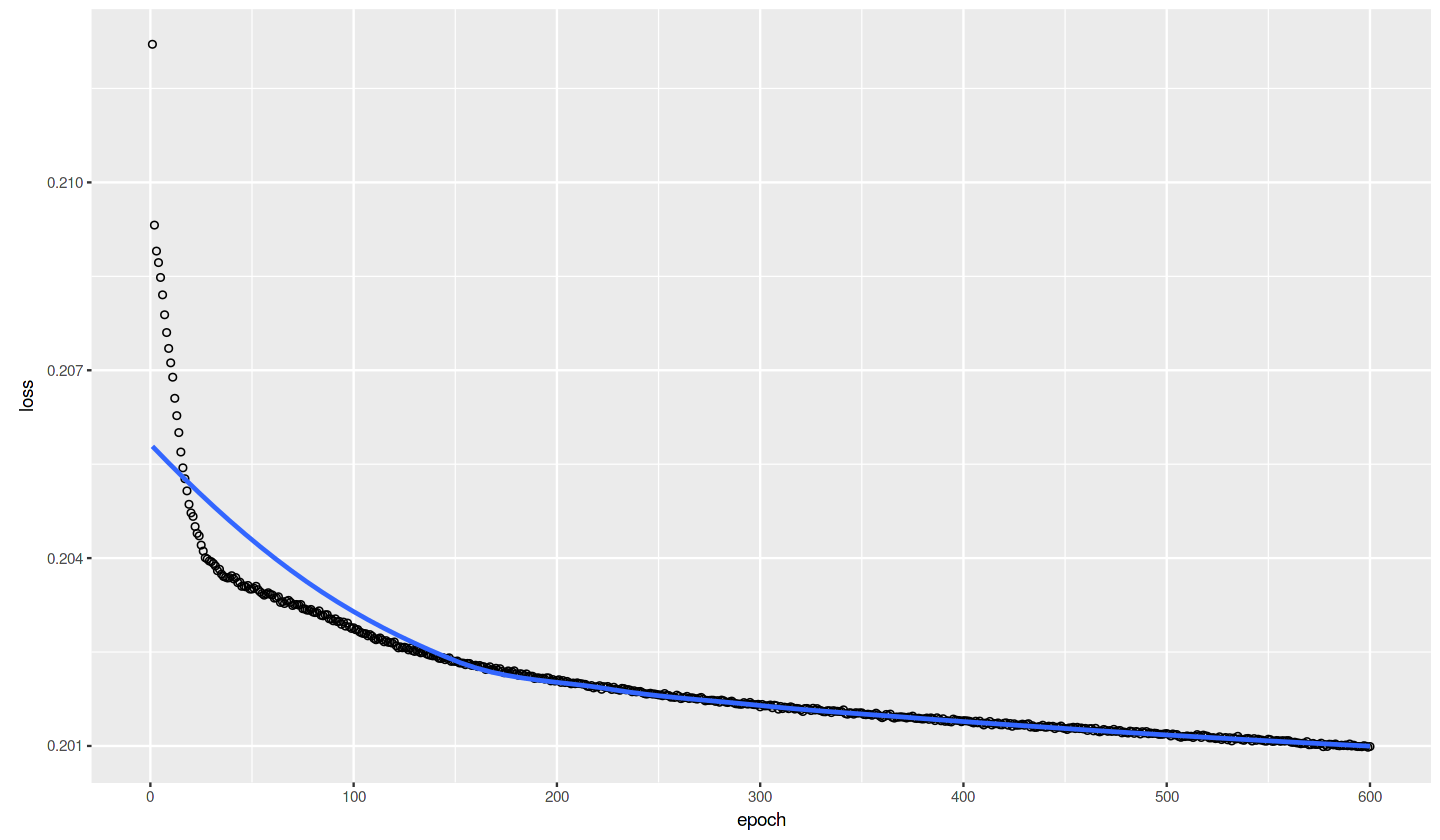

In [46]:
plot(fit)

In [47]:
# calculating the predictions
learn0$fitNNemb <- as.vector(model %>% predict(list(Xlearn, Brlearn, Relearn, Vlearn)))
test0$fitNNemb <- as.vector(model %>% predict(list(Xtest, Brtest, Retest, Vtest)))

# Print claim frequency actual vs predicted
CF2("Claim Frequency NNemb, Test-Sample, Actual/Predicted", test0$ClaimNb,test0$Exposure, test0$fitNNemb,test0$Exposure)

# Print Poisson Deviance
PD2("Poisson Deviance NNemb", learn0$fitNNemb,as.vector(unlist(learn0$ClaimNb)), test0$fitNNemb,as.vector(unlist(test0$ClaimNb)))

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("NNemb", test0$fitNNemb, test0$ClaimNb)

[1] "Claim Frequency NNemb, Test-Sample, Actual/Predicted: 10.05% / 10.00%"

[1] "Poisson Deviance NNemb, Learn/Test: 30.39% / 30.47%"

[1] "GLM2-Improvement-Index (PD test) of NNemb: 140.6%"

Due to an other learn/test-split (different seed and R-version) and the random numbers in Keras/TensorFlow the PD is different to the values listed in Schelldorfer and Wüthrich (2019).

## 6.4 The Combined Actuarial Neural Network with GLM2 (NNGLM)

In [48]:
# Incorporating model GLM2 into a CANN
Vlearn <- as.matrix(log(learn$fitGLM2))
Vtest <- as.matrix(log(test$fitGLM2))
(lambda.hom <- sum(learn$ClaimNb)/sum(learn$fitGLM2))

[1] 1

In [49]:
# repeat model definition

# define the network architecture
Design   <- layer_input(shape = c(q0),  dtype = 'float32', name = 'Design')
VehBrand <- layer_input(shape = c(1),   dtype = 'int32', name = 'VehBrand')
Region   <- layer_input(shape = c(1),   dtype = 'int32', name = 'Region')
LogVol   <- layer_input(shape = c(1),   dtype = 'float32', name = 'LogVol')

BrandEmb = VehBrand %>% 
  layer_embedding(input_dim = BrLabel, output_dim = d, input_length = 1, name = 'BrandEmb') %>%
  layer_flatten(name='Brand_flat')

RegionEmb = Region %>% 
  layer_embedding(input_dim = ReLabel, output_dim = d, input_length = 1, name = 'RegionEmb') %>%
  layer_flatten(name='Region_flat')

Network = list(Design, BrandEmb, RegionEmb) %>% layer_concatenate(name='concate') %>% 
  layer_dense(units=q1, activation='tanh', name='hidden1') %>%
  layer_dense(units=q2, activation='tanh', name='hidden2') %>%
  layer_dense(units=q3, activation='tanh', name='hidden3') %>%
  layer_dense(units=1, activation='linear', name='Network', 
              weights=list(array(0, dim=c(q3,1)), array(log(lambda.hom), dim=c(1))))

Response = list(Network, LogVol) %>% layer_add(name='Add') %>% 
  layer_dense(units=1, activation=k_exp, name = 'Response', trainable=FALSE,
              weights=list(array(1, dim=c(1,1)), array(0, dim=c(1))))

model <- keras_model(inputs = c(Design, VehBrand, Region, LogVol), outputs = c(Response))
model %>% compile(optimizer = optimizer_nadam(), loss = 'poisson')

summary(model)

Model: "model_1"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
VehBrand (InputLayer)     [(None, 1)]       0                                   
________________________________________________________________________________
Region (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
BrandEmb (Embedding)      (None, 1, 2)      22       VehBrand[0][0]             
________________________________________________________________________________
RegionEmb (Embedding)     (None, 1, 2)      44       Region[0][0]               
________________________________________________________________________________
Design (InputLayer)       [(None, 7)]       0                                   
________________________________________________________________________________
Brand_flat 

In [50]:
# re-fitting the neural network with GLM2-CANN
{t1 <- proc.time()
  fit <- model %>% fit(list(Xlearn, Brlearn, Relearn, Vlearn), Ylearn, epochs=200, 
                       batch_size=10000, verbose=0, validation_split=0)
  (proc.time()-t1)}

   user  system elapsed 
229.819  16.461 137.660 

`geom_smooth()` using formula 'y ~ x'



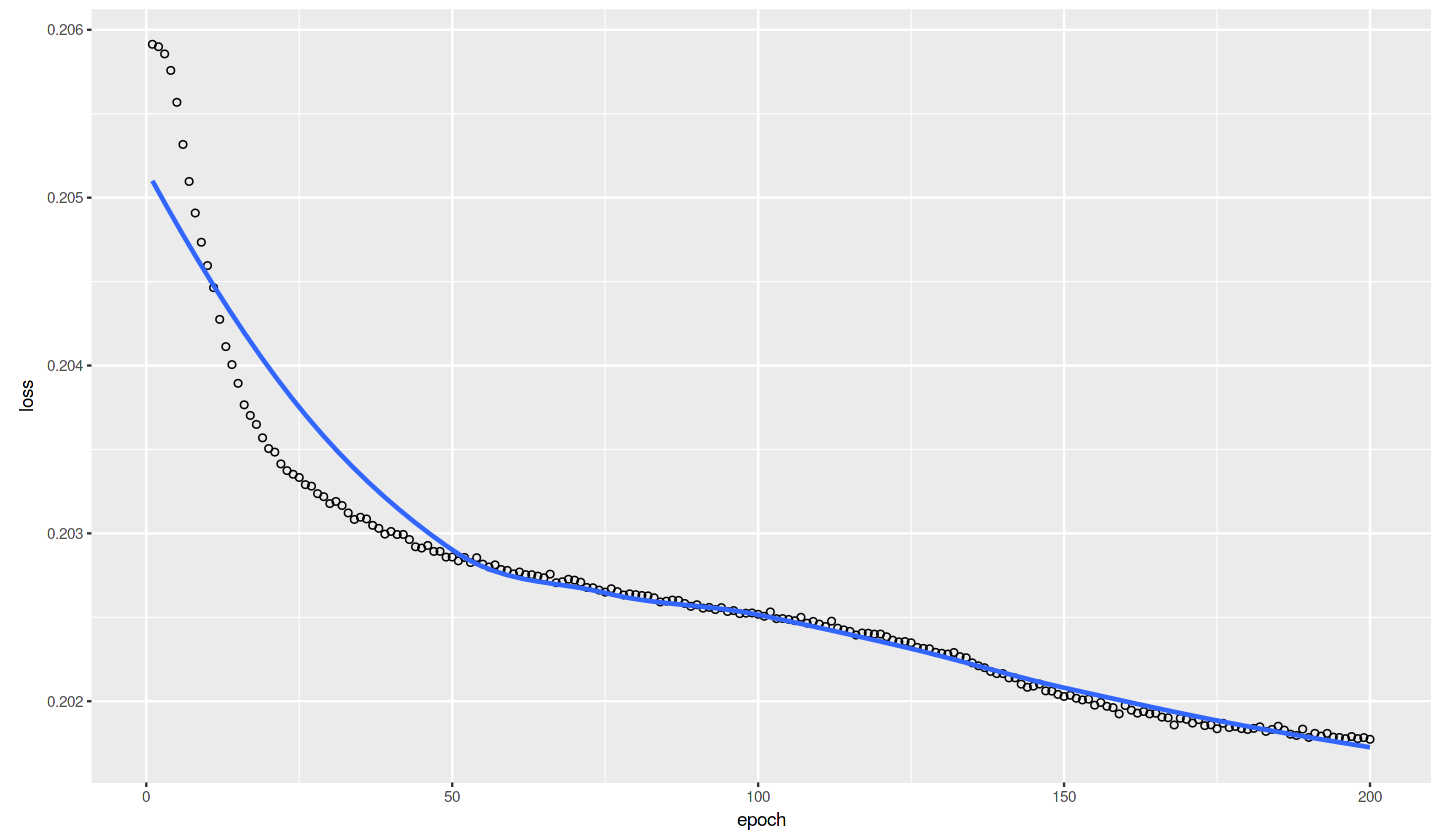

In [51]:
plot(fit)

In [52]:
# calculating the predictions
learn1$fitNNGLM <- as.vector(model %>% predict(list(Xlearn, Brlearn, Relearn, Vlearn)))
test1$fitNNGLM <- as.vector(model %>% predict(list(Xtest, Brtest, Retest, Vtest)))

# Print claim frequency actual vs predicted
CF2("Claim Frequency NNGLM, Test-Sample, Actual/Predicted", test1$ClaimNb,test1$Exposure, test1$fitNNGLM,test1$Exposure)

# Print Poisson Deviance
PD2("Poisson Deviance NNGLM", learn1$fitNNGLM,as.vector(unlist(learn1$ClaimNb)), test1$fitNNGLM,as.vector(unlist(test1$ClaimNb)))

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("NNGLM", test1$fitNNGLM, test1$ClaimNb)

[1] "Claim Frequency NNGLM, Test-Sample, Actual/Predicted: 10.05% / 10.41%"

[1] "Poisson Deviance NNGLM, Learn/Test: 30.58% / 30.52%"

[1] "GLM2-Improvement-Index (PD test) of NNGLM: 137.2%"

## 6.5 The monotonic CANN (NNGLMc)
To obtain monotonous behavior in BonusMalus, we remove it from the feature list of the neural network.

In [53]:
# changing the matrices (exclude BonusMalus, col18)
features <- c(14:17, 20:21) # definition of feature variables (non-categorical)
q0 <- length(features)
print(paste("Number of basic features (without VehBrand and Region):",q0))
# learning data
Xlearn <- as.matrix(learn[, features])  # design matrix learning sample
Brlearn <- as.matrix(learn$VehBrandX)
Relearn <- as.matrix(learn$RegionX)
Ylearn <- as.matrix(learn$ClaimNb)
# testing data
Xtest <- as.matrix(test[, features])    # design matrix test sample
Brtest <- as.matrix(test$VehBrandX)
Retest <- as.matrix(test$RegionX)
Ytest <- as.matrix(test$ClaimNb)

# Incorporating model GLM2 into a CANN
Vlearn <- as.matrix(log(learn$fitGLM2))
Vtest <- as.matrix(log(test$fitGLM2))
(lambda.hom <- sum(learn$ClaimNb)/sum(learn$fitGLM2))

[1] "Number of basic features (without VehBrand and Region): 6"


[1] 1

In [54]:
# repeat model definition

# define the network architecture
Design   <- layer_input(shape = c(q0),  dtype = 'float32', name = 'Design')
VehBrand <- layer_input(shape = c(1),   dtype = 'int32', name = 'VehBrand')
Region   <- layer_input(shape = c(1),   dtype = 'int32', name = 'Region')
LogVol   <- layer_input(shape = c(1),   dtype = 'float32', name = 'LogVol')

BrandEmb = VehBrand %>% 
  layer_embedding(input_dim = BrLabel, output_dim = d, input_length = 1, name = 'BrandEmb') %>%
  layer_flatten(name='Brand_flat')

RegionEmb = Region %>% 
  layer_embedding(input_dim = ReLabel, output_dim = d, input_length = 1, name = 'RegionEmb') %>%
  layer_flatten(name='Region_flat')

Network = list(Design, BrandEmb, RegionEmb) %>% layer_concatenate(name='concate') %>% 
  layer_dense(units=q1, activation='tanh', name='hidden1') %>%
  layer_dense(units=q2, activation='tanh', name='hidden2') %>%
  layer_dense(units=q3, activation='tanh', name='hidden3') %>%
  layer_dense(units=1, activation='linear', name='Network', 
              weights=list(array(0, dim=c(q3,1)), array(log(lambda.hom), dim=c(1))))

Response = list(Network, LogVol) %>% layer_add(name='Add') %>% 
  layer_dense(units=1, activation=k_exp, name = 'Response', trainable=FALSE,
              weights=list(array(1, dim=c(1,1)), array(0, dim=c(1))))

model <- keras_model(inputs = c(Design, VehBrand, Region, LogVol), outputs = c(Response))
model %>% compile(optimizer = optimizer_nadam(), loss = 'poisson')

summary(model)

Model: "model_2"
________________________________________________________________________________
Layer (type)              Output Shape      Param #  Connected to               
VehBrand (InputLayer)     [(None, 1)]       0                                   
________________________________________________________________________________
Region (InputLayer)       [(None, 1)]       0                                   
________________________________________________________________________________
BrandEmb (Embedding)      (None, 1, 2)      22       VehBrand[0][0]             
________________________________________________________________________________
RegionEmb (Embedding)     (None, 1, 2)      44       Region[0][0]               
________________________________________________________________________________
Design (InputLayer)       [(None, 6)]       0                                   
________________________________________________________________________________
Brand_flat 

The model is now 20 weights smaller.

In [55]:
# re-fitting the neural network with GLM2-CANN
{t1 <- proc.time()
  fit <- model %>% fit(list(Xlearn, Brlearn, Relearn, Vlearn), Ylearn, epochs=200, 
                       batch_size=10000, verbose=0, validation_split=0)
  (proc.time()-t1)}

   user  system elapsed 
220.447  15.690 131.194 

`geom_smooth()` using formula 'y ~ x'



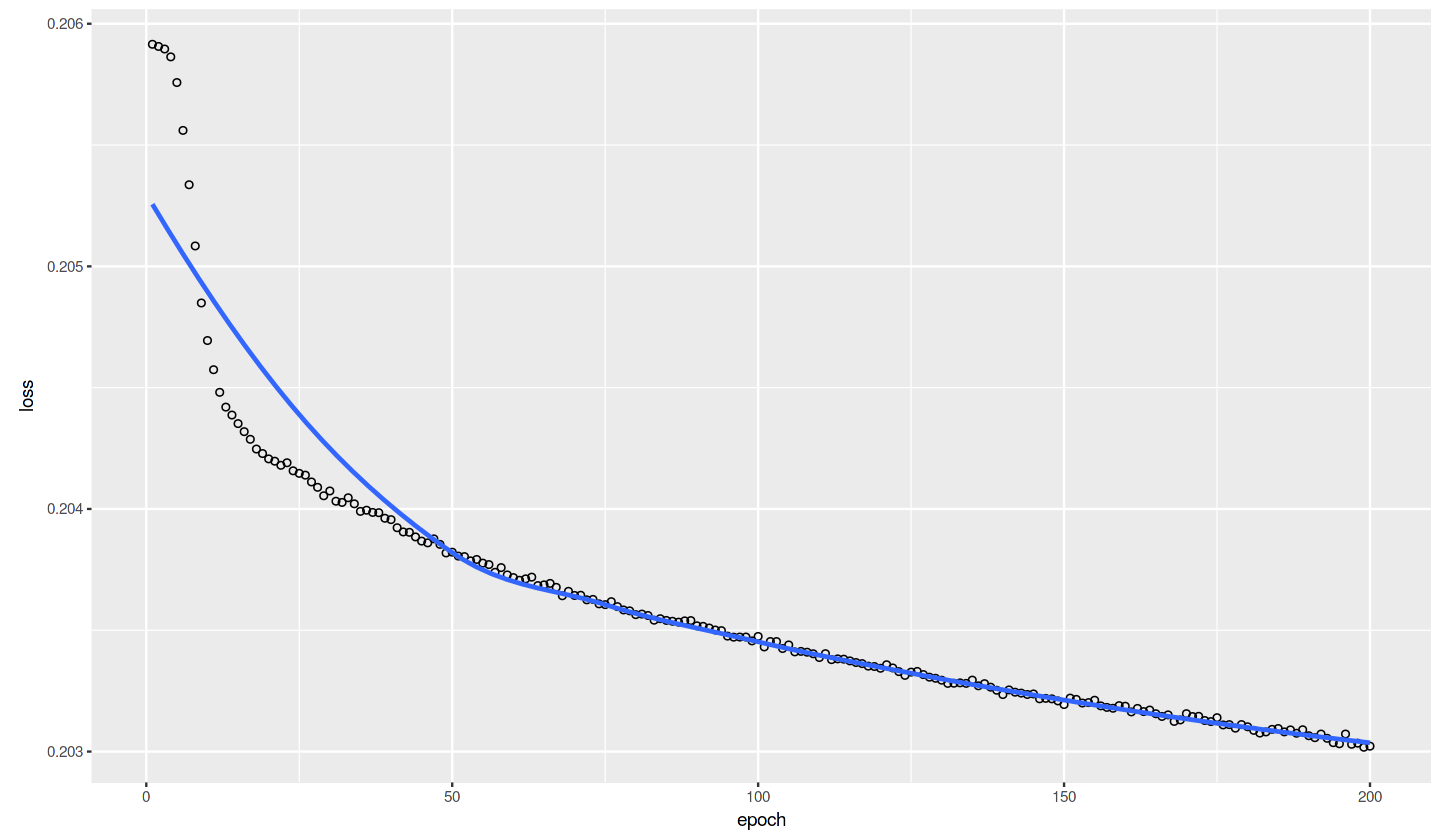

In [56]:
plot(fit)

In [57]:
# calculating the predictions
learn1$fitNNGLMc <- as.vector(model %>% predict(list(Xlearn, Brlearn, Relearn, Vlearn)))
test1$fitNNGLMc <- as.vector(model %>% predict(list(Xtest, Brtest, Retest, Vtest)))

# Print Poisson Deviance
PD2("Poisson Deviance NNGLMc", learn1$fitNNGLMc,as.vector(unlist(learn1$ClaimNb)), test1$fitNNGLMc,as.vector(unlist(test1$ClaimNb)))

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("NNGLMc", test1$fitNNGLMc, test1$ClaimNb)

[1] "Poisson Deviance NNGLMc, Learn/Test: 30.81% / 30.69%"

[1] "GLM2-Improvement-Index (PD test) of NNGLMc: 127.3%"

Although the Bonus Malus class is only included in the embedded model GLM2 and is not available to the neural network for interaction, there is still an improvement over GLM2. However, since this is no improvement compared to the already seen classic model GLMM, we will not pursue this path.

<a id="ch7"></a>
# 7. Gradient Boosting Approach with XGBoost

Boosting is an approach to improve the predictions that result from a decision tree (see example in chapter 1.2). In contrast to fitting a single large, potentially overfitting decision tree to the data, the boosting approach learns slowly instead. With gradient boosting, a decision tree is fitted to the residuals of the current model (instead of the result Y). This new decision tree is added into the fitting function with a weight "eta", which is referred to as the "learning rate", in order to update the residuals again. Typically, eta is less than 10% and the process is repeated over a hundred times. Boosting can over-fit if this process is repeated too often and the trees are too deep. The depth of the decision trees, the learning rate (eta) and the "number of rounds" are important hyper parameters that have to be tuned.

XGBoost (eXtreme Gradient Boosting) is a fast gradient boosting implementation and is known for winning many data science competitions after its 2014 release. Meanwhile faster and potentially more competitive algorithms such as lightGBM and CatBoost are available. Nevertheless, XGBoost is still very popular with R users. It can be downloaded from CRAN and there is a lot of information available, even general information for actuaries, e.g. https://www.actuaries.org.uk/news-and-insights/news/article-fitting-data-xgboost (11 October 2019).




## 7.1 Feature Pre-Processing


In [58]:
dat2 <- dat[,c(1:12,14)]  # keep original variables and fitGLM2

dat2$Area <- as.integer(dat2$Area)

# one-hot encoding for Region and VehBrand
dat2 <- as.data.frame(model.matrix( ~ 0 +. ,data = dat2)) 
dim(dat2)
head(dat2)

[1] 678013     43

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrandB1,VehBrandB10,⋯,RegionR54,RegionR72,RegionR73,RegionR74,RegionR82,RegionR83,RegionR91,RegionR93,RegionR94,fitGLM2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,0.10,4,5,0,55,50,0,0,⋯,0,0,0,0,1,0,0,0,0,0.03581595
2,3,1,0.77,4,5,0,55,50,0,0,⋯,0,0,0,0,1,0,0,0,0,0.27578278
3,5,1,0.75,2,6,2,52,50,0,0,⋯,0,0,0,0,0,0,0,0,0,0.07239686
4,10,1,0.09,2,7,0,46,50,0,0,⋯,0,1,0,0,0,0,0,0,0,0.02086083
5,11,1,0.84,2,7,0,46,50,0,0,⋯,0,1,0,0,0,0,0,0,0,0.19470104
6,13,1,0.52,5,6,2,38,50,0,0,⋯,0,0,0,0,0,0,0,0,0,0.04501318


In [59]:
# choosing learning and test sample
dat2$fold <- fold
learn <- dat2[dat2$fold != 5,]    # 80%
test <- dat2[ dat2$fold == 5,]    # 20%
CF2("Claim Frequency (Actual) Learn/Test", learn$ClaimNb,learn$Exposure, test$ClaimNb,test$Exposure)

# exclude any feature with string "fit|fold|Claim|Exp|IDpol"
features.xgb <- setdiff( 1:length(learn) ,  grep("fit|fold|Claim|Exp|IDpol", names(dat2)  ))
head(learn[,features.xgb])

[1] "Claim Frequency (Actual) Learn/Test: 10.06% / 10.05%"

,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrandB1,VehBrandB10,VehBrandB11,VehBrandB12,VehBrandB13,⋯,RegionR53,RegionR54,RegionR72,RegionR73,RegionR74,RegionR82,RegionR83,RegionR91,RegionR93,RegionR94
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4,5,0,55,50,0,0,0,1,0,⋯,0,0,0,0,0,1,0,0,0,0
3,2,6,2,52,50,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
4,2,7,0,46,50,0,0,0,1,0,⋯,0,0,1,0,0,0,0,0,0,0
5,2,7,0,46,50,0,0,0,1,0,⋯,0,0,1,0,0,0,0,0,0,0
6,5,6,2,38,50,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
7,5,6,2,38,50,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


In [60]:
suppressMessages(library(xgboost))

# construct xgb.DMatrices (these are the internal data structures used by XGBoost during training)  
dtrain <- xgb.DMatrix(data = data.matrix(learn[,features.xgb]), label = learn$ClaimNb)
dtest <- xgb.DMatrix(data = data.matrix(test[,features.xgb]), label = test$ClaimNb)

#bm
ddat.0y <- xgb.DMatrix(data = data.matrix(dat2[,features.xgb]), label = dat2$ClaimNb) # Original BM
dat.1y <- dat2
dat.1y$BonusMalus <- Bonus(dat2$BonusMalus) # set new BonusMalus class
features.xgb.1y <- setdiff( 1:length(dat.1y ) ,  grep("fit|fold|Claim|Exp|IDpol", names(dat.1y)))
ddat.1y <- xgb.DMatrix(data = data.matrix(dat.1y[,features.xgb.1y]), label = dat.1y$ClaimNb)

# Set base margins / offset
setinfo(dtrain,"base_margin",log(learn$Exposure))
setinfo(dtest,"base_margin",log(test$Exposure))
#bm
setinfo(ddat.0y,"base_margin",log(dat2$Exposure))
setinfo(ddat.1y,"base_margin",log(dat.1y$Exposure))

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

## 7.2 XGBoost with tuned hyperparameters
The hyper parameters were found by a random search with GPU support.

In [61]:
# train model
{t1 <- proc.time()
  fit.xgb <- xgb.train(data =dtrain,
                         objective='count:poisson',
                         nrounds = 1200,
                         max_depth = 7,
                         eta = 0.025,
                         colsample_by_tree = 0.8,
                         subsample = 0.9,
                         min_child_weight = 10,
                         tree_method = "hist")
(proc.time()-t1)}

   user  system elapsed 
766.221   0.000 199.726 

### 7.2.1 Predictive Power

In [62]:
## make predictions
learn$fitXGB <- predict(fit.xgb , newdata = dtrain)
test$fitXGB <- predict(fit.xgb, newdata = dtest)
#bm
dat$fitXGB.0y.dat <- predict(fit.xgb , newdata = ddat.0y)
dat$fitXGB.1y.dat <- predict(fit.xgb , newdata = ddat.1y)

# Print claim frequency actual vs predicted
CF2('Claim Frequency XGB, Test-Sample, Actual/Predicted', test$ClaimNb,test$Exposure, test$fitXGB,test$Exposure)

# Print Poisson Deviance
PD2("Poisson Deviance XGB", learn$fitXGB,learn$ClaimNb, test$fitXGB,test$ClaimNb)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("XGB", test$fitXGB, test$ClaimNb)

[1] "Claim Frequency XGB, Test-Sample, Actual/Predicted: 10.05% / 10.06%"

[1] "Poisson Deviance XGB, Learn/Test: 28.89% / 29.89%"

[1] "GLM2-Improvement-Index (PD test) of XGB: 175.5%"

#### Wow, more than 170%! This is a real jump in PD improvement compared to the best GLMs (index ~ 130%).

### 7.2.2 Feature Importance
Plot feature importance as a bar graph: The gain represents the fractional contribution of each feature to the model based on the total gain of this feature’s splits. Higher percentage means a more important predictive feature.


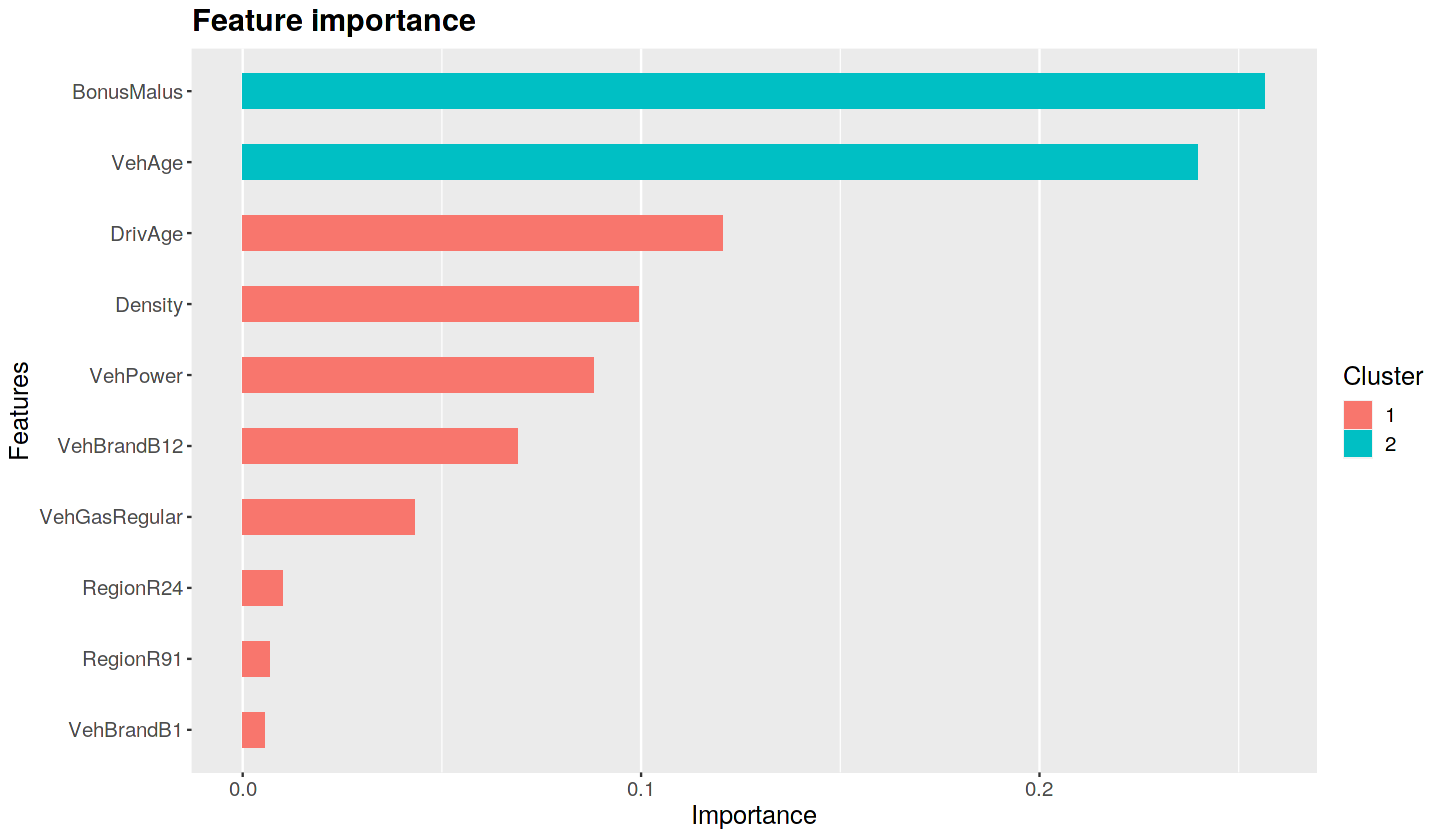

In [63]:
importance_matrix <- xgb.importance(dimnames(dtrain)[[2]], model = fit.xgb)
xgb.ggplot.importance(importance_matrix,top_n=10) + theme(text = element_text(size=15))

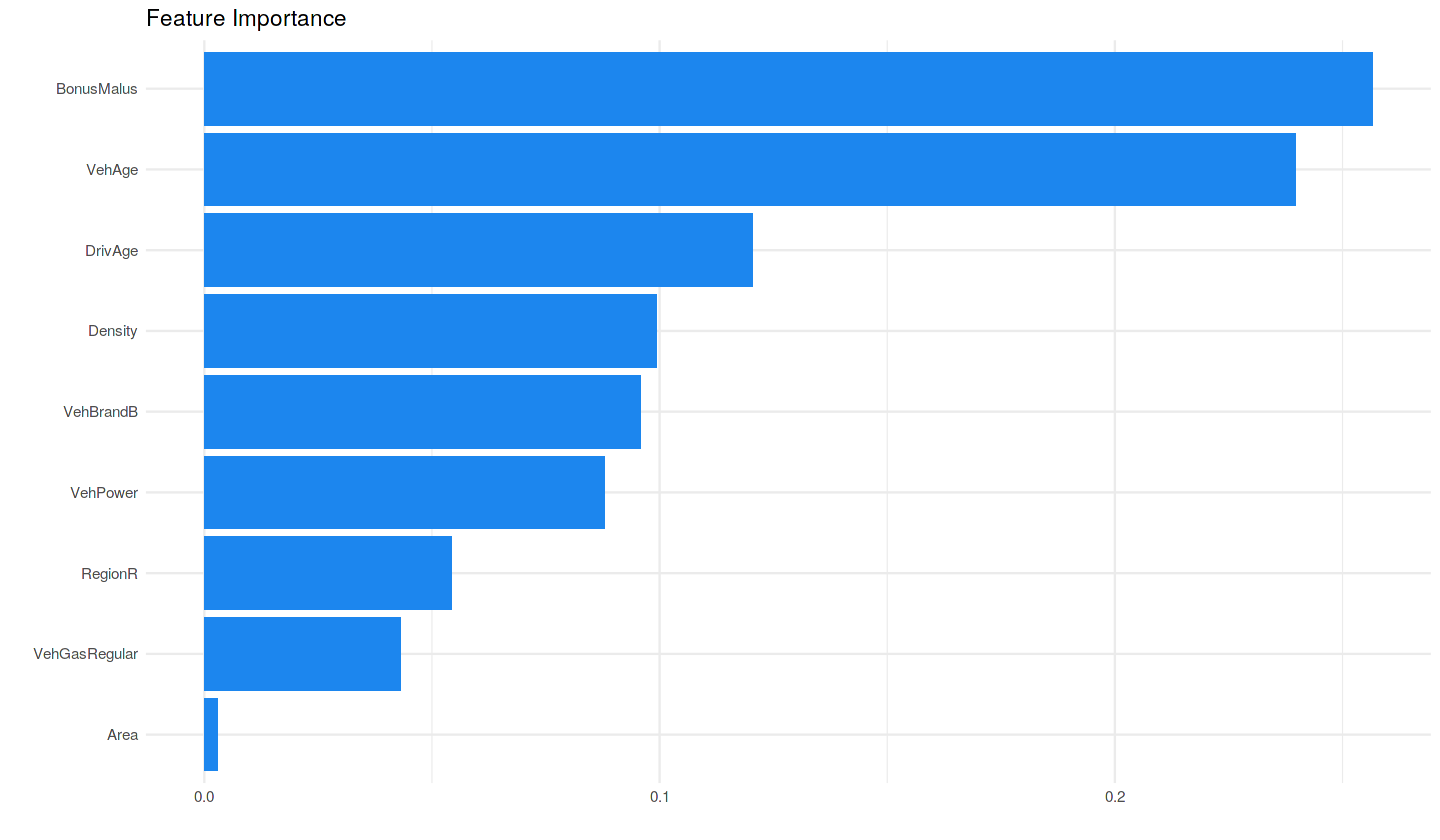

In [64]:
# Summing up the importance of the one-hot encoded features
imp <- xgb.importance(model = fit.xgb)
to_delete <- c("1|2|3|4|5|6|7|8|9|0")
imp$Feature <- str_remove_all(imp$Feature, to_delete)
imp %>% group_by(Feature) %>%
  summarise(Gain = sum(Gain), Cover = sum(Cover), Frequency = sum(Frequency)) %>%
  ggplot(aes(x = reorder(Feature, Gain ), y = Gain)) +
  geom_bar(stat = 'identity', fill = 'dodgerblue2') +
  labs(x = '', y = '', title = 'Feature Importance') +
  coord_flip() +
  theme_minimal()

### 7.2.3 Model Complexity
To get an impression about the model complexity we plot the model trees deepness:

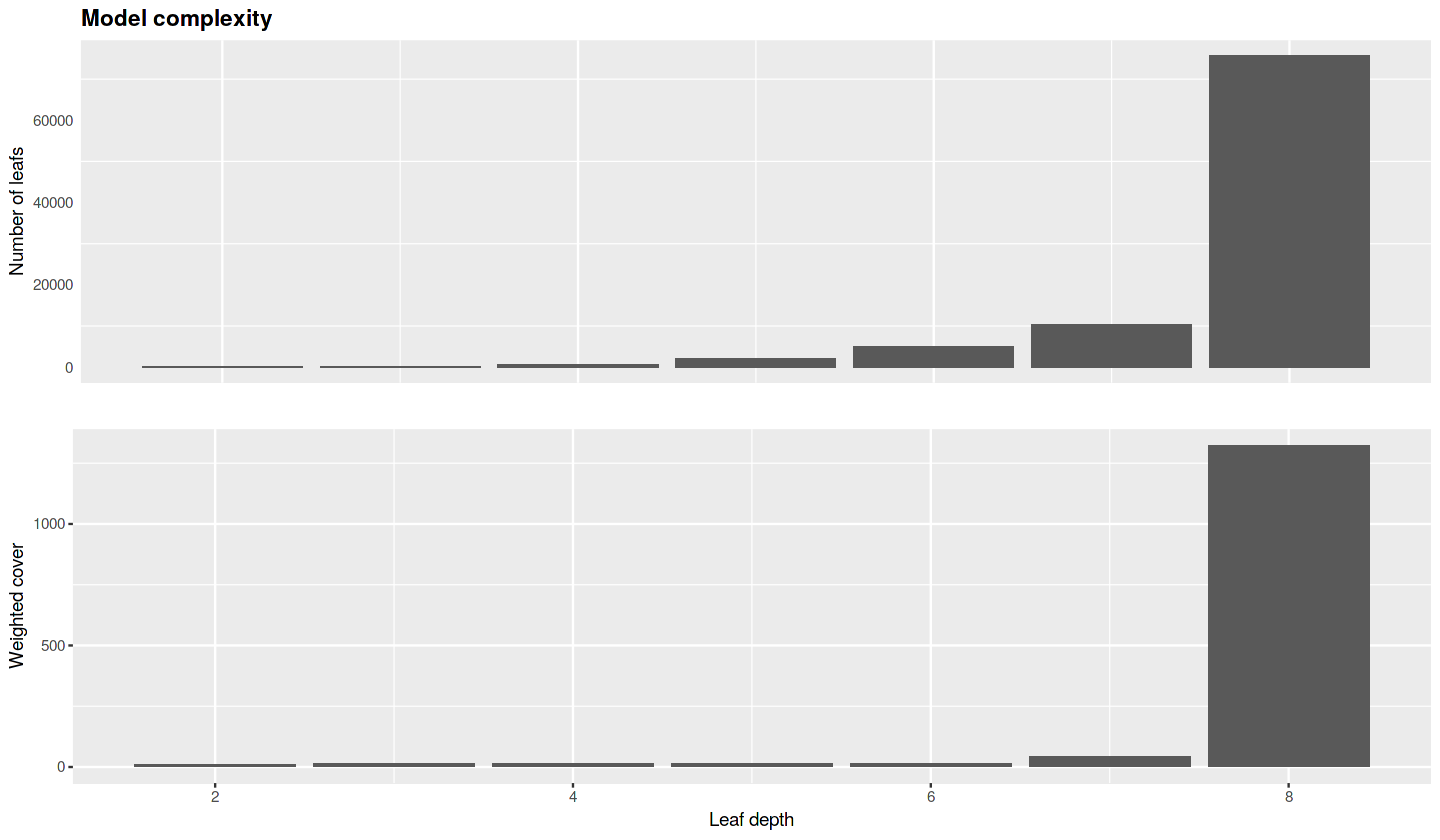

In [65]:
xgb.ggplot.deepness(fit.xgb)
# 1. plot:  the distribution of the number of leafs in a tree model at a certain depth;
# 2. plot: the distribution of average weighted number of observations ("cover") ending up in leafs at certain depth.

This model is not small. There are several thousand leaves in the maximum tree depth. So how can we interpret this model?

### 7.2.4 SHAP contribution dependency plots
SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. SHAP contribution dependency plots display the estimated contributions of a feature to model prediction for each individual case. For more information we recommend Christoph Molnar's book "Interpretable Machine Learning", Chapter 5 https://christophm.github.io/interpretable-ml-book/ (as of March 16, 2020) and the documentation of xgboost: https://cran.r-project.org/web/packages/xgboost/xgboost.pdf .

We generate the SHAP contribution dependency plots for the three most important features (see b):

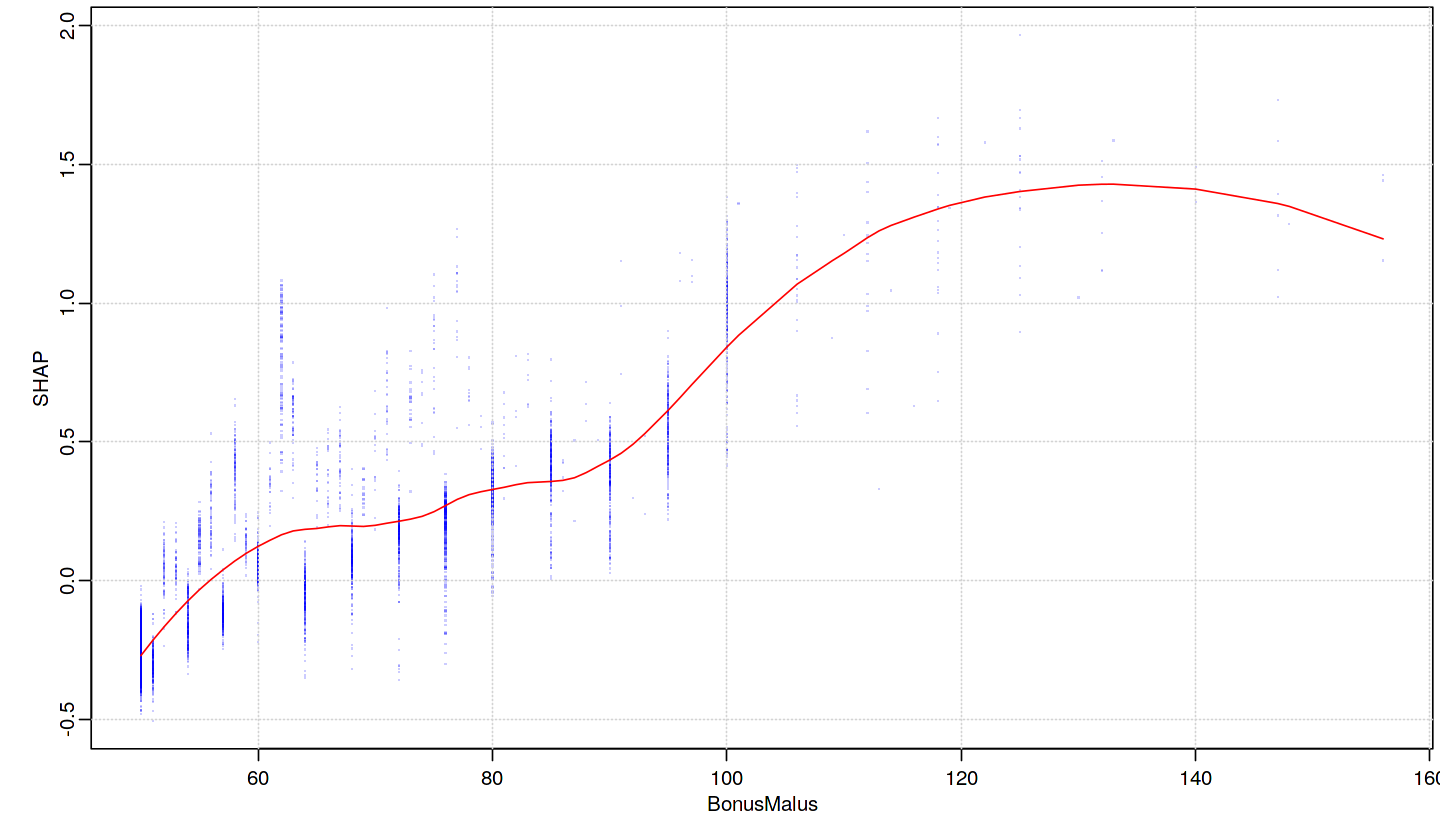

In [66]:
xgb.plot.shap(data.matrix(learn[,features.xgb]), model = fit.xgb, subsample = 0.02, features = "BonusMalus")

The SHAP contribution for BonusMalus is not strictly monotonous. Furthermore, there appears to be an additional, less populated band with a higher SHAP contribution. Does claim frequency depend on exposure?

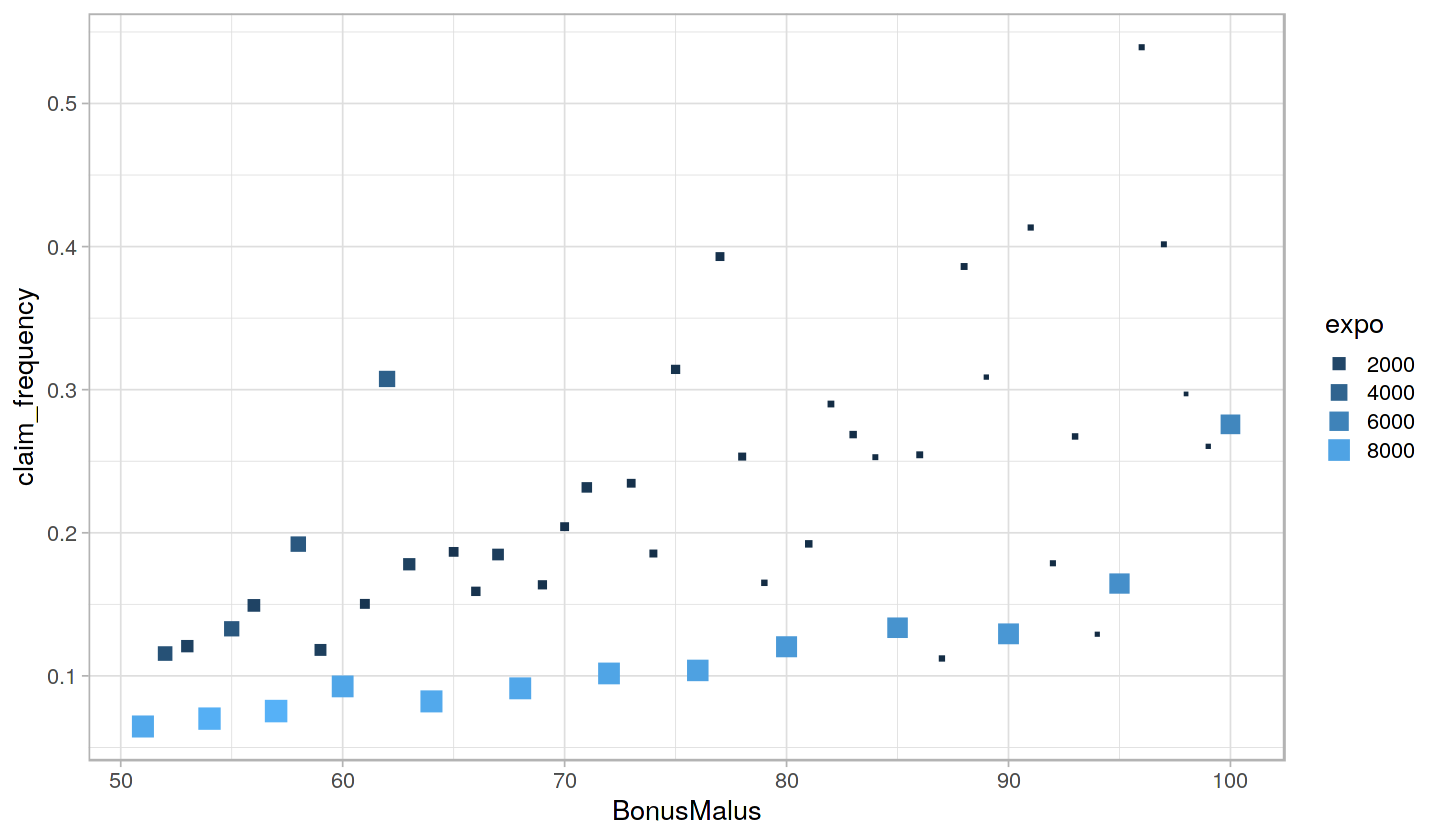

In [67]:
# BonuMalus: Does claim frequency depend on exposure?
dat2 %>% filter(BonusMalus >50 & BonusMalus<=100) %>% 
  group_by(BonusMalus) %>% 
  summarize(claim_frequency=sum(as.double(ClaimNb))/sum(Exposure), expo=sum(Exposure)) %>% 
  ggplot(aes(x=BonusMalus, y=claim_frequency, colour=expo)) + 
    geom_point(aes(size = expo), shape=15) +
    guides(colour='legend') +
    theme_light(base_size = 16)

Very interesting. Either we see effects of bonus malus demotion or there might be more than one bonus-malus-system in the data. 

This behavior and monotonicity in general is dealt with in the next chapter. 

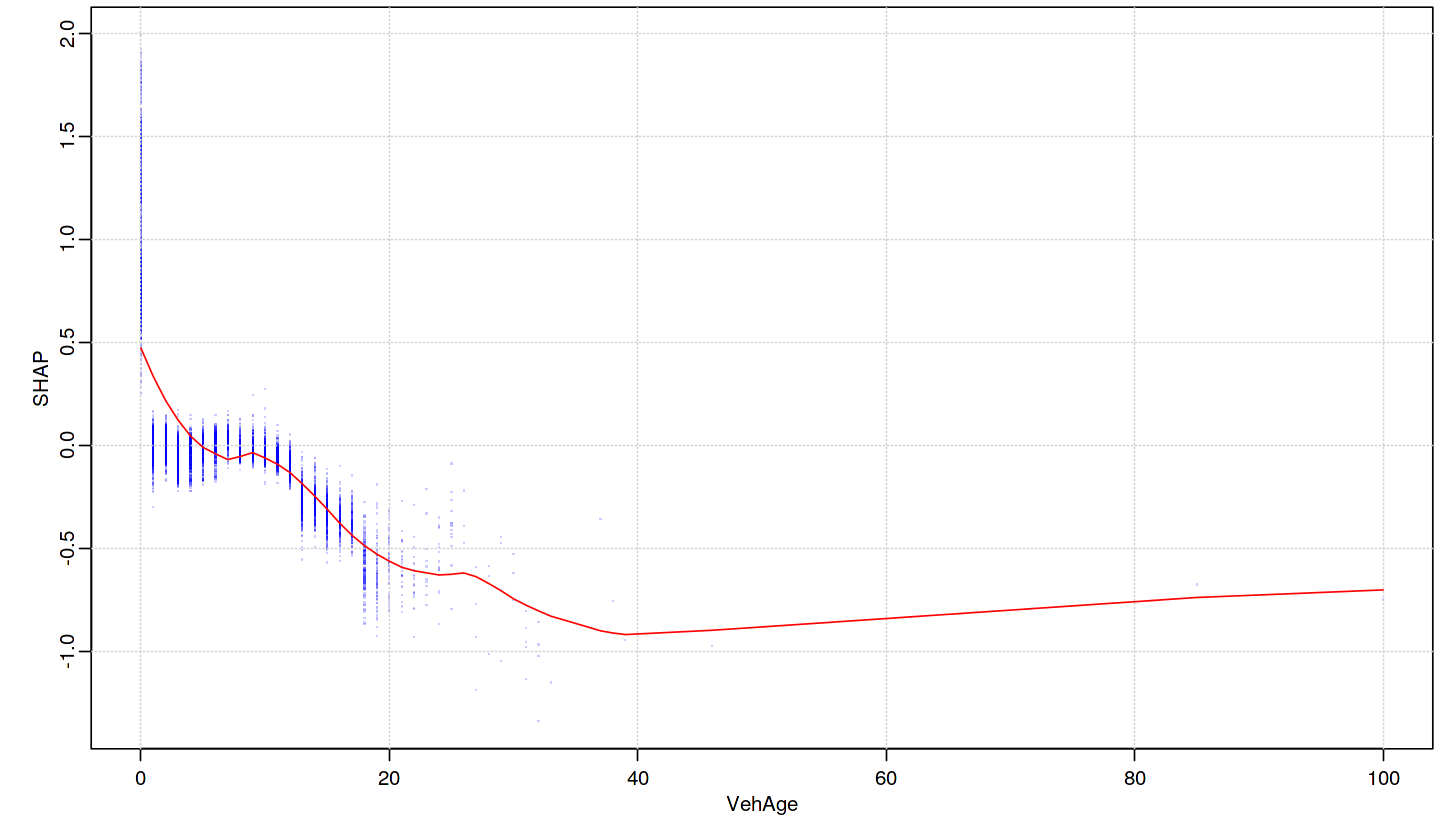

In [68]:
xgb.plot.shap(data.matrix(learn[,features.xgb]), model = fit.xgb, subsample = 0.02, features = "VehAge")

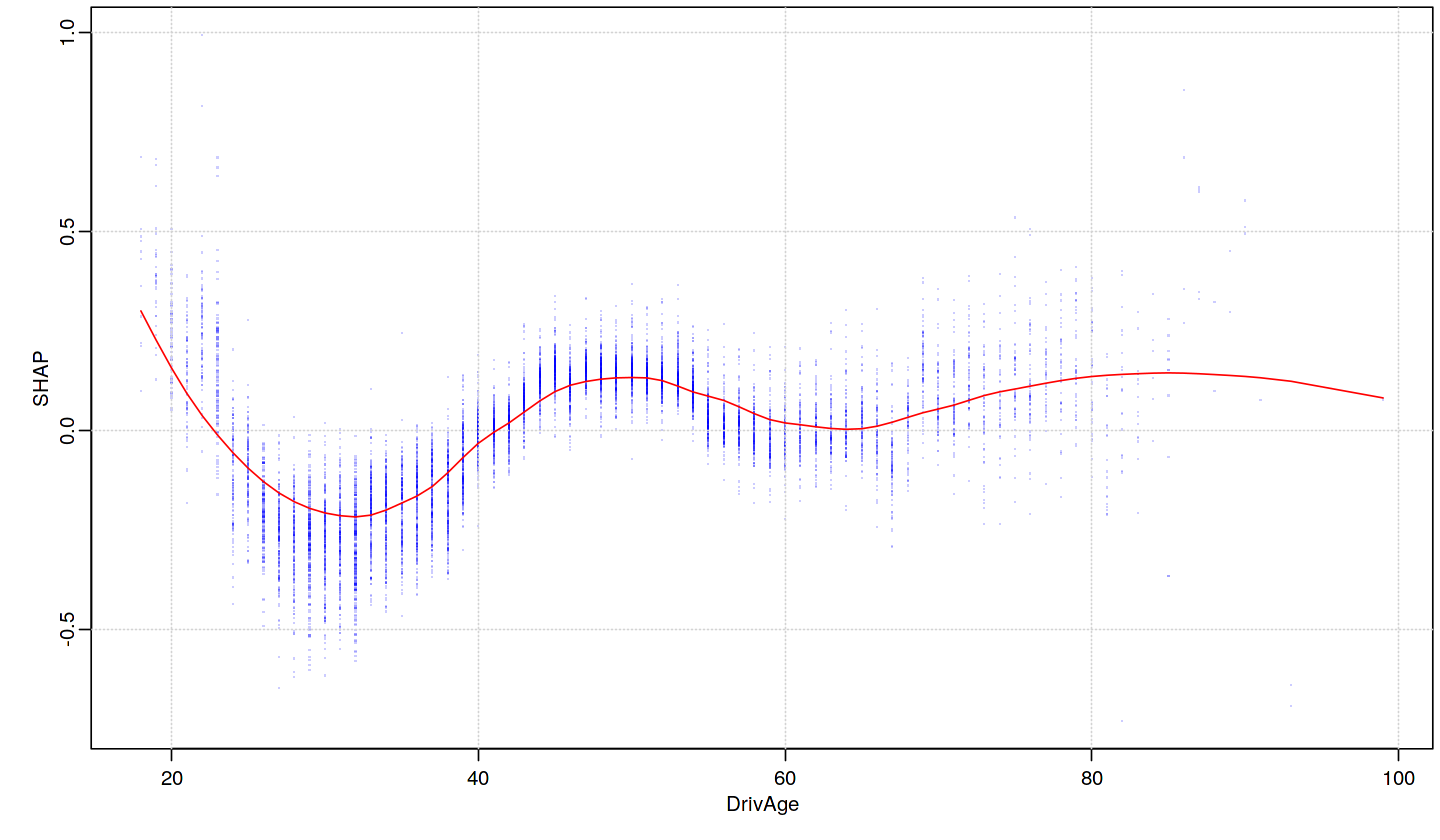

In [69]:
xgb.plot.shap(data.matrix(learn[,features.xgb]), model = fit.xgb, subsample = 0.02, features = "DrivAge")

The SHAP contributions of VehAge and DrivAge seem to be plausible. 

There are further SHAP plots available, a) to summarize the effects of all features and b) to visualize the single prediction's explanation, see the SHAP-author's page https://github.com/slundberg/shap and the R-Package ‘SHAPforxgboost' https://liuyanguu.github.io/post/2019/07/18/visualization-of-shap-for-xgboost/ .

## 7.3 XGBoost and Monotonic Constraints
As we have seen above (SHAP), so far XGBoost does not consider monotonicity on features like BonusMalus or annual mileage (the later is unfortunately not included in this data set). This can be fixed using monotonic constraints to incorporate expected increasing or decreasing monotonous relationships into tariff structures. 

This is not a proposal for the treatment of bonus-malus. The bonus-malus class is merely a placeholder for a feature with desired monotonically increasing or decreasing behavior.

In [70]:
# create monotonic constraints vector: increasing: +1, decreasing: -1, unconstraint: 0
mtc <- c(rep( 0, length(features.xgb)))
mtc[5] <- 1 # BonusMalus increasing (features.xgb omits the first 3 variables thus  8->5)
#mtc[3] <- -1 # VehAge decreasing (just as an example)
#print(mtc)
#head(dat2,1)[4:42] # check feature names

In [71]:
## XGBoost with monotone constraint (same hyper parameter as in chapter 7.2)

{t1 <- proc.time()
  fit.xgbc <- xgb.train(data =dtrain,
                         objective='count:poisson',
                         nrounds = 1200,
                         max_depth = 7,
                         eta = 0.025,
                         colsample_by_tree = 0.8,
                         subsample = 0.9,
                         min_child_weight = 10,
                         tree_method = "hist",
                         monotone_constraints = mtc)
(proc.time()-t1)}

   user  system elapsed 
776.051   0.000 202.195 

In [72]:
## make predictions
learn$fitXGBc <- predict(fit.xgbc , newdata = dtrain)
test$fitXGBc <- predict(fit.xgbc, newdata = dtest)
dat$fitXGBc.0y.dat <- predict(fit.xgbc , newdata = ddat.0y)
dat$fitXGBc.1y.dat <- predict(fit.xgbc , newdata = ddat.1y)

# Print claim frequency actual vs predicted
CF2('Claim Frequency XGBc (monotonic), Test-Sample, Actual/Predicted', test$ClaimNb,test$Exposure, test$fitXGBc,test$Exposure)

# Print Poisson Deviance
PD2("Poisson Deviance XGBc (monotonic)", learn$fitXGBc,learn$ClaimNb, test$fitXGBc,test$ClaimNb)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
Benchmark.GLM2("XGBc (monotonic)", test$fitXGBc, test$ClaimNb)

[1] "Claim Frequency XGBc (monotonic), Test-Sample, Actual/Predicted: 10.05% / 10.06%"

[1] "Poisson Deviance XGBc (monotonic), Learn/Test: 29.23% / 30.05%"

[1] "GLM2-Improvement-Index (PD test) of XGBc (monotonic): 166.0%"

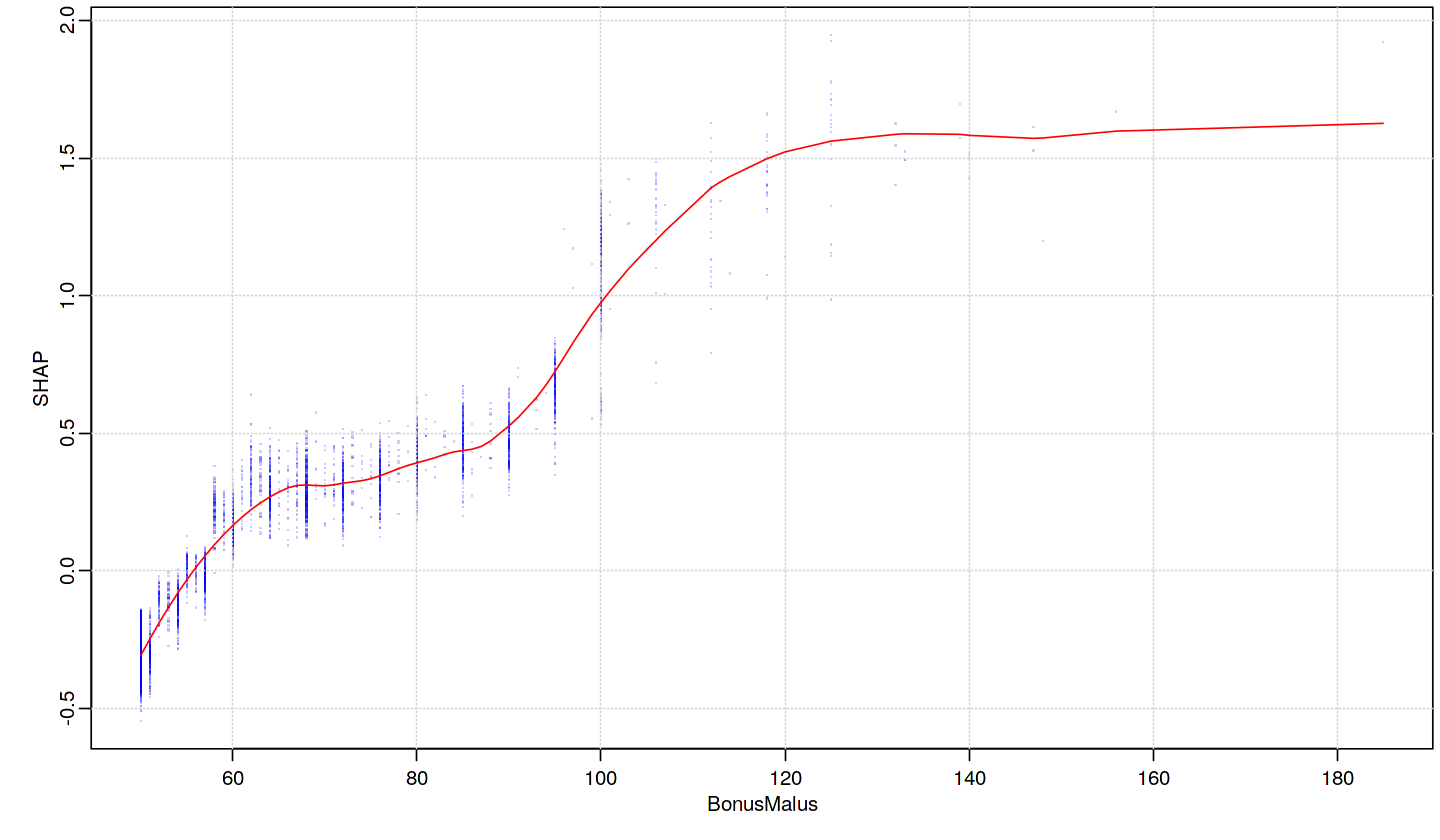

In [73]:
xgb.plot.shap(data.matrix(learn[,features.xgb]), model = fit.xgbc, subsample = 0.02, features = "BonusMalus")

The constraint SHAP contribution of BonusMalus looks much smoother than in chapter 7.2.4.

The monotonic constraint comes with a cost. The Poisson Deviance is not as good as without constraint, the GLM2-Improvement-Index drops from 175.9% to 165.8%. However, this is still much better than then best classical and neural network models and can be further improved by re-tuning the hyper parameters.

## 7.4 XGBoost and Monotonic Constraints, re-tuned
The hyper parameters for the XGBoost model with monotonic constraints were found again by a random search with GPU support.

In [74]:
## XGBoost with monotone constraint (same hyper parameter as in chapter 7.2) and modified hyperparameter
# tuning: lowest score with gamma
{t1 <- proc.time()
  fit.xgbct <- xgb.train(data =dtrain,
                         objective='count:poisson',
                         nrounds = 1500,
                         max_depth = 10,
                         eta = 0.015,
                         colsample_by_tree = 0.60,
                         subsample = 0.95,
                         gamma = 0.80,
                         min_child_weight = 2,
                         tree_method = "hist",
                         monotone_constraints = mtc)
(proc.time()-t1)}

    user   system  elapsed 
1230.317    0.000  318.216 

In [75]:
## make predictions
learn$fitXGBct <- predict(fit.xgbct , newdata = dtrain)
test$fitXGBct <- predict(fit.xgbct, newdata = dtest)
dat$fitXGBct.0y.dat <- predict(fit.xgbct , newdata = ddat.0y)
dat$fitXGBct.1y.dat <- predict(fit.xgbct , newdata = ddat.1y)

# Print claim frequency actual vs predicted
CF2('Claim Frequency XGBct (monotonic, re-tuned), Test-Sample, Actual/Predicted', test$ClaimNb,test$Exposure, test$fitXGBct,test$Exposure)

# Print Poisson Deviance
PD2("Poisson Deviance XGBct (monotonic, re-tuned)", learn$fitXGBct,learn$ClaimNb, test$fitXGBct,test$ClaimNb)

# Improvement in Poisson Deviance on test set compared to GLM2-INT-Improvement
test$fit.cf <- test$Exposure * sum(learn$ClaimNb)/sum(learn$Exposure) # (recalculate INT-Model)
Benchmark.GLM2("XGBct (monotonic, re-tuned)", test$fitXGBct, test$ClaimNb)

[1] "Claim Frequency XGBct (monotonic, re-tuned), Test-Sample, Actual/Predicted: 10.05% / 10.09%"

[1] "Poisson Deviance XGBct (monotonic, re-tuned), Learn/Test: 27.61% / 29.97%"

[1] "GLM2-Improvement-Index (PD test) of XGBct (monotonic, re-tuned): 170.4%"

In [76]:
tail(dat)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,⋯,fitGLM4,fitGLM4.1y,fitGLM5,fitGLM5.1y,fitXGB.0y.dat,fitXGB.1y.dat,fitXGBc.0y.dat,fitXGBc.1y.dat,fitXGBct.0y.dat,fitXGBct.1y.dat
,<dbl>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<int>,<fct>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
678008,6114325,0,0.005479452,E,6,4,40,68,B12,Regular,⋯,0.0007054213,6.966924e-04,0.0007131374,7.021880e-04,0.0006095683,0.0005627978,0.0006710676,0.0006710676,0.0007094677,0.0007094677
678009,6114326,0,0.002739726,E,4,0,54,50,B12,Regular,⋯,0.0010974170,2.220446e-16,0.0013690857,NaN,0.0016459491,0.0016459491,0.0015837922,0.0015837922,0.0015382807,0.0015382807
678010,6114327,0,0.002739726,E,4,0,41,95,B12,Regular,⋯,0.0026417242,2.300848e-03,0.0018293657,1.676776e-03,0.0015021063,0.0014718798,0.0016275793,0.0015968627,0.0015188723,0.0015165781
678011,6114328,0,0.002739726,D,6,2,45,50,B12,Diesel,⋯,0.0002190507,2.220446e-16,0.0002134275,NaN,0.0002674745,0.0002674745,0.0002615702,0.0002615702,0.0002768328,0.0002768328
678012,6114329,0,0.002739726,B,4,0,60,50,B12,Regular,⋯,0.0009229658,2.220446e-16,0.0012087370,NaN,0.0008070579,0.0008070579,0.0008919355,0.0008919355,0.0007538658,0.0007538658
678013,6114330,0,0.002739726,B,7,6,29,54,B12,Diesel,⋯,0.0001250402,9.545177e-05,0.0001201849,9.100425e-05,0.0001816959,0.0002309679,0.0001752094,0.0001534033,0.0001999074,0.0001833026


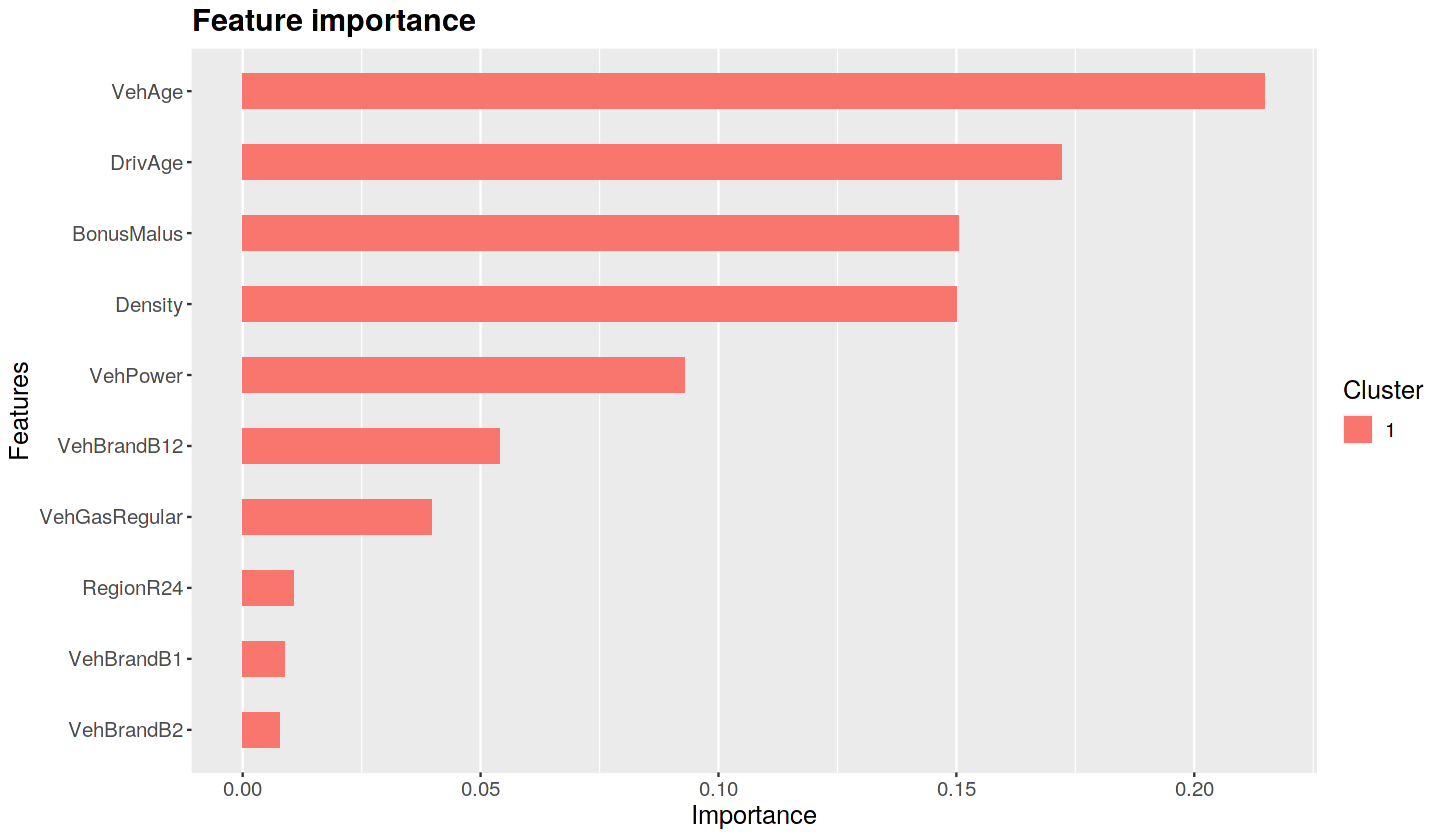

In [77]:
importance_matrix <- xgb.importance(dimnames(dtrain)[[2]], model = fit.xgbct)
xgb.ggplot.importance(importance_matrix,top_n=10) + theme(text = element_text(size=15))

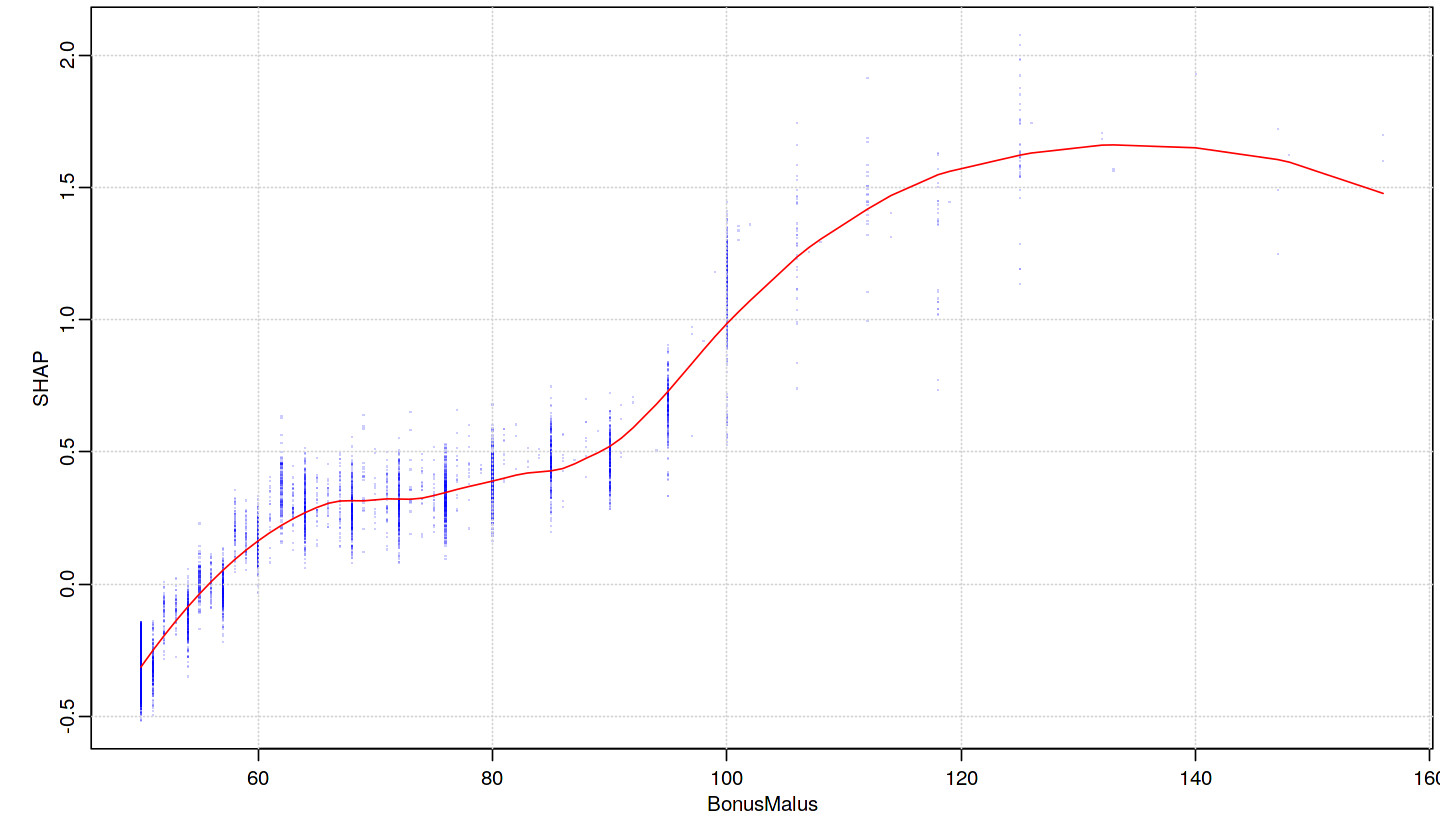

In [78]:
xgb.plot.shap(data.matrix(learn[,features.xgb]), model = fit.xgbct, subsample = 0.02, features = "BonusMalus")

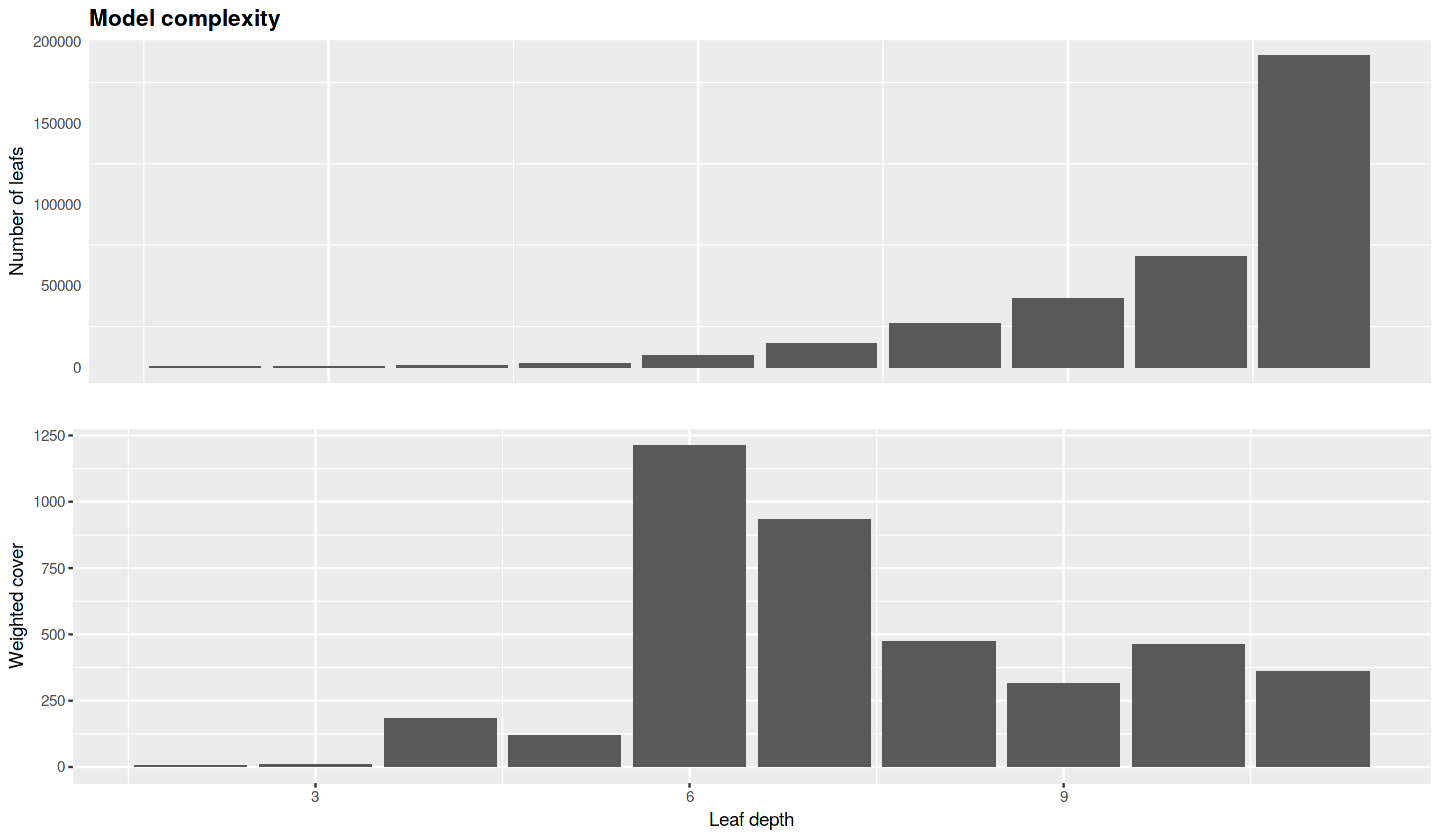

In [79]:
xgb.ggplot.deepness(fit.xgbct)

This model is quite deep. The trees add up to over 20,000 leaves. To check over-fitting next we apply cross-validation for all models.

<a id="ch8"></a>
# 8. Model Comparison, Monotonic Constraints and Remarks


## 8.1 Model Comparison

Now we extend the cross-validation loop from chapter 5 (GLMs) to all models. Since this takes considerably more execution time and - depending on the number of folds - can exceed the Kaggle notebook runtime limits, we perform this task locally and present the results with the same CV samples as above.

Let us first compare the Poisson Deviances:

<img src="https://i.postimg.cc/ZKxQHwSZ/V02-CV-RES-PD-order-seed42.jpg" width="800">

Since a substantial part of the uncertainty is caused by differences between folds we again calculate and compare the relative improvement with respect to the models INT ("no model") and our benchmark-model GLM2:

<img src="https://i.postimg.cc/jjLksKJd/V02-CV-RES-Imp-order-seed42.jpg" width="800">

We can see a clear winner here: XGBoost is by far the most accurate model for predicting claim frequencies. This applies to all calculated XGB-variants. 

## 8.2 Monotonic Constrains Example: BonusMalus

Which variant should now be chosen? To answer this question, let us look at practical aspects and examine the desired monotonous behaviour of bonus-malus-descent. If the policy is claim-free, the predicted claim frequency (which here is a proxy for the next year's premium) must not rise by this.

In [80]:
# Calculate  differences after BonusMalus-improving

diff <- function(y0, y1)  {
  di <- (y1 - y0)  / y0 * 100 
  return(di)
}

differ <- data.frame(BonusMalus = dat$BonusMalus)

differ$GLM2 <- diff(dat$fitGLM2, dat$fitGLM2.1y)
differ$GLM2S<- diff(dat$fitGLM2S, dat$fitGLM2S.1y)
differ$GLMM <- diff(dat$fitGLMM, dat$fitGLMM.1y )
differ$GLM4 <- diff(dat$fitGLM4, dat$fitGLM4.1y)
differ$GLM5 <- diff(dat$fitGLM5, dat$fitGLM5.1y )
differ$XGB  <- diff(dat$fitXGB.0y.dat, dat$fitXGB.1y.dat)
differ$XGBc <- diff(dat$fitXGBc.0y.dat, dat$fitXGBc.1y.dat)
differ$XGBct<- diff(dat$fitXGBct.0y.dat, dat$fitXGBct.1y.dat)

# Filter BonusMalus 54 to 125 
differ <- differ %>% filter(BonusMalus > 53 & BonusMalus < 126 )

# New BonusMalus after one year: BM.1y
differ$BM.1y <- Bonus(differ$BonusMalus)

nrow(differ)/nrow(dat) # proportion BonusMalus 54 to 125
head(differ)
summary(differ)

[1] 0.396836

,BonusMalus,GLM2,GLM2S,GLMM,GLM4,GLM5,XGB,XGBc,XGBct,BM.1y
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,68,-8.843628,-8.723449,-9.344702,-2.0940537,4.669609,-7.615716,0.000000,-2.1712273,64
2,68,-8.843628,-8.723449,-9.344702,-2.0940537,4.669609,-7.615700,0.000000,-2.1712251,64
3,90,-10.929521,-10.782710,-11.541109,-12.4765961,-13.240027,2.209393,-2.859612,-1.8595228,85
4,90,-10.929521,-10.782710,0.000000,-12.4765961,-7.431567,-2.576991,-4.149214,-9.6644000,85
5,100,-10.929521,-10.782710,-11.541109,-17.1805475,-17.442229,-41.415976,-44.988772,-44.8512992,95
6,76,-8.843628,-8.723449,0.000000,-0.9584117,4.571875,9.247749,0.000000,-0.6471565,72


   BonusMalus          GLM2             GLM2S              GLMM        
 Min.   : 54.00   Min.   :-14.959   Min.   :-14.763   Min.   :-15.776  
 1st Qu.: 60.00   1st Qu.:-10.930   1st Qu.:-10.783   1st Qu.:-11.541  
 Median : 72.00   Median : -8.844   Median : -8.723   Median : -9.345  
 Mean   : 74.18   Mean   : -8.967   Mean   : -8.846   Mean   : -9.215  
 3rd Qu.: 85.00   3rd Qu.: -6.709   3rd Qu.: -6.617   3rd Qu.: -7.094  
 Max.   :125.00   Max.   : -6.709   Max.   : -6.617   Max.   :  0.000  
      GLM4              GLM5              XGB               XGBc        
 Min.   :-24.890   Min.   :-26.021   Min.   :-79.364   Min.   :-73.253  
 1st Qu.:-14.609   1st Qu.:-15.114   1st Qu.:-21.544   1st Qu.:-17.157  
 Median : -8.604   Median : -9.032   Median :-10.163   Median : -9.054  
 Mean   : -9.246   Mean   : -9.540   Mean   :-11.301   Mean   :-11.656  
 3rd Qu.: -3.145   3rd Qu.: -3.542   3rd Qu.: -1.019   3rd Qu.: -1.851  
 Max.   :  3.321   Max.   :  9.158   Max.   :230.952   Max

Warning message:
“Removed 39550 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 16 rows containing missing values (geom_bar).”


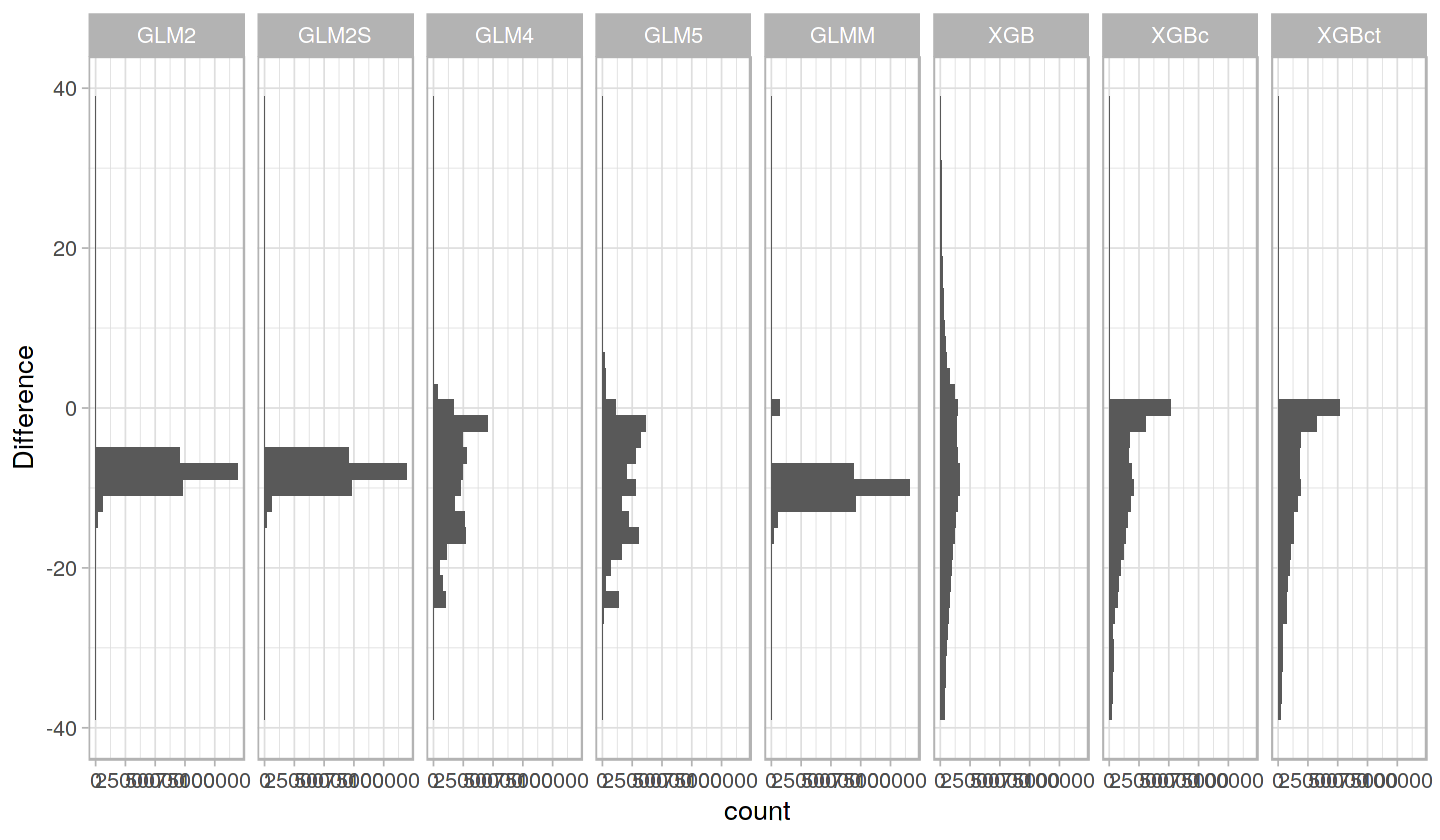

In [81]:
# transform data from wide to long
differ.long <- gather(differ[2:9],model,Difference,GLM2,GLM2S,GLMM,GLM4,GLM5,XGB,XGBc,XGBct)

# plot difference for each model
ggplot(differ.long, aes(Difference)) + 
  geom_histogram(binwidth=2) +
  facet_grid(. ~model) + 
  xlim(-40, 40) +
  coord_flip() +
  theme_light(base_size = 16)

As expected, the classical models GLM2, GLM2S, GLMM and the gradient boosting models XGBc and XGBct are monotonous (decreasing).  While the annual difference for the classical models is small, it can be quite large for the gradient boosting models. Again, this is not a proposal for the treatment of bonus-malus. The bonus-malus class is merely a placeholder for a feature with desired monotonically increasing or decreasing behaviour, such as an annual mileage.

## 8.3 Advantages and Disadvantages of Gradient Boosting
The applied gradient boosting method uses decision tree based model ensembles. The main advantage of powerful gradient boosting tools such as XGBoost is the high prediction quality that can be achieved with them, as shown in sections 7.2 and 7.4. Although the computing time required for this is generally longer compared to GLMs, it is usually shorter than that of comparable high-performance neural networks and can also be reduced by an order of magnitude using GPUs.

The resulting score code can be quite extensive and, depending on existing systems, may require new technologies in its application. If the data does not reflect the current market situation, the score code should not simply be adjusted. Instead, it is recommended to modify the data before modeling accordingly (for example, using a simulation). 

Compared to easily understandable small decision trees, a boosted sequence of over a thousand (rather deep) trees is of course difficult to visualize directly. Section 7.2 showed how the results can nevertheless be checked for plausibility and further instruments for interpretation were listed. 

<a id="ch9"></a>
# 9. Results and Summary


In the following diagram, all classical models and XGBoost models that meet the monotony criterion under consideration are listed once again. To demonstrate stability, the analysis is repeated with other sample compositions (seed=100).

<img src="https://i.postimg.cc/kGxj1hZJ/CV-RESc-Imp-order-seed100.jpg" width="800">

In summary, it can be stated that in the data set examined here, the XGBoost models prove to be the superior forecasting models, even taking into account the tariff system. While the classical models achieve a corresponding prediction improvement of less than 30%, a prediction improvement of over 60% is achieved with Gradient Boosting.

To ensure interpretability, the feature importance, the tree depth as well as the "SHAP contribution dependency plots" based on game theory were examined for the partly extensive gradient boosting models.

On our journey through the world of machine learning methods, we curiously started with deep learning and ended with powerful gradient boosting.

### References:
 
Schelldorfer, J., Wüthrich, M. V. (2019) "Nesting Classical Actuarial Models into Neural Networks", SSRN-Preprint 3320525 (Version of January 22, 2019).


Version overview: Major changes

* V2, Ch.6: Set the number of epochs for the neural networks to the values given in the reference in Table 3 (NNemb: 600, NNGLM/CANN: 200). Ch.8.3 "Advantages and Disadvantages of Gradient Boosting" added. 
